In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from helper import *
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate, Flatten, Dropout


2025-04-15 14:19:03.794889: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 14:19:03.810236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744719543.826366    4724 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744719543.830859    4724 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744719543.844828    4724 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [4]:
# for our data
def load_images(image_dir, mask_dir,margin=0.4):
    images, masks = [], []

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.jpg') or f.endswith('.png')])

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image and mask
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Convert to grayscale for face detection
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        if len(faces) > 0:
            # Use the first detected face
            (x, y, w, h) = faces[0]

            margin_x = int(w * margin)  # margin for width
            margin_y = int(h * margin)  # margin for height

            # Adjust the coordinates to include the margin
            x = max(x - margin_x, 0)
            y = max(y - margin_y, 0)
            w = min(w + 2 * margin_x, image.shape[1] - x)
            h = min(h + 2 * margin_y, image.shape[0] - y)

            # Crop image and mask using the same coordinates
            cropped_img = image[y:y+h, x:x+w]
            cropped_mask = mask[y:y+h, x:x+w]
        else:
            # If no face detected, use full image and mask
            cropped_img = image
            cropped_mask = mask

        # Resize to match expected input size
        resized_img = cv2.resize(cropped_img, (128, 128))
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        binary_mask = np.where(cropped_mask > 0, 1, 0).astype(np.uint8)
        resized_mask = cv2.resize(binary_mask, (128, 128))


        images.append(gray_img)
        masks.append(resized_mask)

    return images, masks

# for online dataset

# def load_images(image_dir, mask_dir):
#     images, masks = [], []
#     for file in os.listdir(image_dir):
#         if file.endswith('.jpg'):
#             image = cv2.imread(image_dir + file,cv2.IMREAD_GRAYSCALE)
#             image = cv2.resize(image, (128,128))
#             images.append(image)
#     for file in os.listdir(mask_dir):
#         if file.endswith('.jpg'):
#             mask = cv2.imread(mask_dir + file, cv2.IMREAD_GRAYSCALE)
#             binary_mask = np.where(mask > 0, 1, mask)
#             # binary_mask *= 255
#             binary_mask = cv2.resize(binary_mask, (128, 128))
#             masks.append(binary_mask)
#     return images, masks
#     # for file in os.listdir(image_dir):
#     #     if file.endswith('.jpg'):
#     #         image = cv2.imread(image_dir + file,cv2.IMREAD_GRAYSCALE)
#     #         image = cv2.resize(image, (128,128))
#     #         images.append(image)
#     # for file in os.listdir(mask_dir):
#     #     if file.endswith('.png'):
#     #         mask = cv2.imread(mask_dir + file,cv2.IMREAD_GRAYSCALE)
#     #         mask = cv2.resize(mask, (128, 128))
#     #         masks.append(mask)
#     # return images, masks

In [5]:
images, masks = load_images("data_ours/images_temp/", "data_ours/masks_temp/")
# images, masks = load_images("data/images/","data/masks/")
print(len(images))
print(len(masks))
print(np.unique(masks[0]))

122
122
[0 1]


In [6]:
images_augmented, masks_augmented = augmentData(images, masks)
print(len(images_augmented))
print(len(masks_augmented))

1464
1464


In [7]:
def plot_images(images, masks,num):
    plt.figure(figsize=(18, 9))
    for i in range(num):
        idx = random.randint(0, len(images))
        img = images[idx]
        mask = masks[idx]
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f'Real Image, index = {idx}')
        plt.axis('off')
        plt.subplot(2, 4, i + num + 1)
        plt.imshow(mask)
        plt.title(f'Segmented Image, index = {idx}')
        plt.axis('off')
        del img, mask


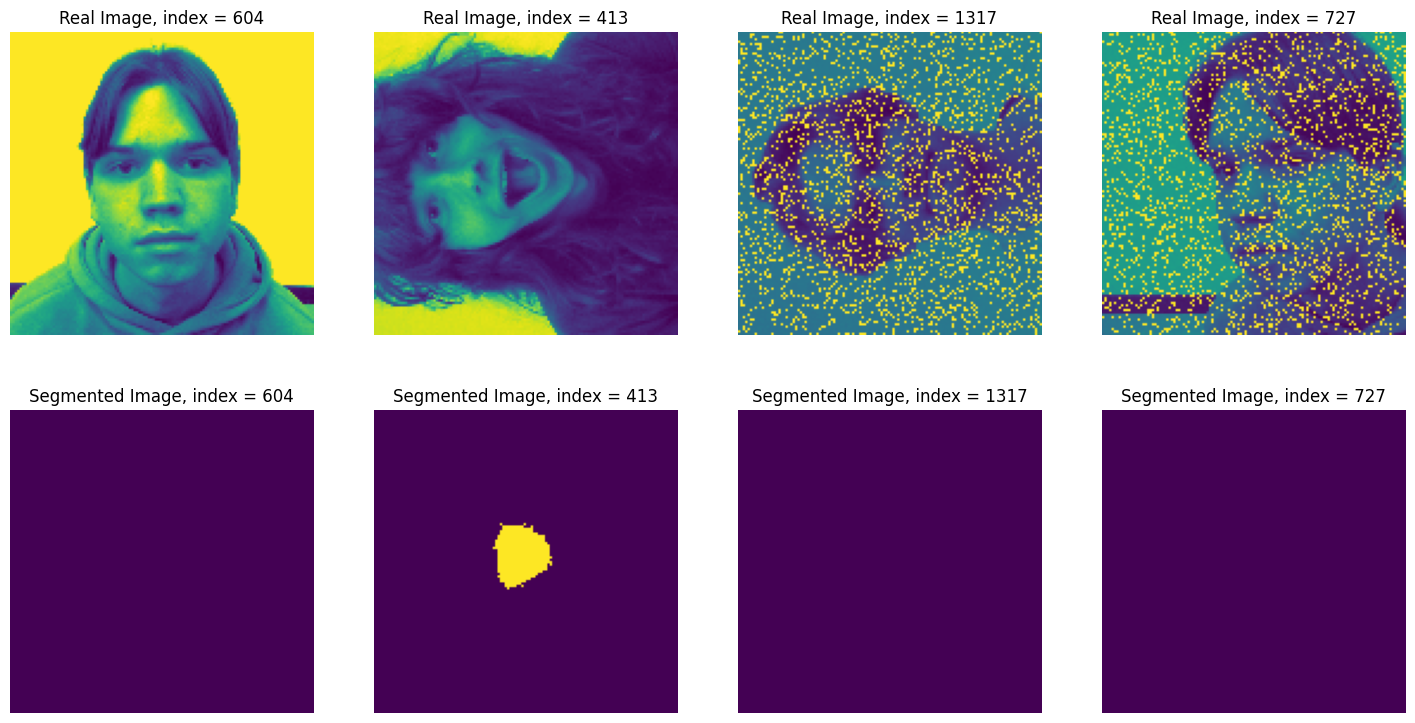

In [8]:
plot_images(images_augmented, masks_augmented,4)
# plot_images(images,masks,4)

In [10]:
images = np.array(images_augmented)
masks = np.array(masks_augmented)

In [11]:

# Set random seed
seed = 16
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

#splitting the images and masks into train, test and split
indices = np.arange(len(images))
np.random.shuffle(indices)

images = images[indices]
masks = masks[indices]

total_size = len(images)
train_split = int(total_size * 0.6)
test_val_split = int(total_size * 0.2)

images_train = images[:train_split]
masks_train = masks[:train_split]

images_val = images[train_split:train_split + test_val_split]
masks_val = masks[train_split:train_split + test_val_split]

images_test = images[train_split + test_val_split:]
masks_test = masks[train_split + test_val_split:]

del images, masks

print(f'The length of images and masks for training is {len(images_train)} and {len(masks_train)} respectively')
print(f'The length of images and masks for validation is {len(images_val)} and {len(masks_val)} respectively')
print(f'The length of images and masks for testing is {len(images_test)} and {len(masks_test)} respectively')

The length of images and masks for training is 878 and 878 respectively
The length of images and masks for validation is 292 and 292 respectively
The length of images and masks for testing is 294 and 294 respectively


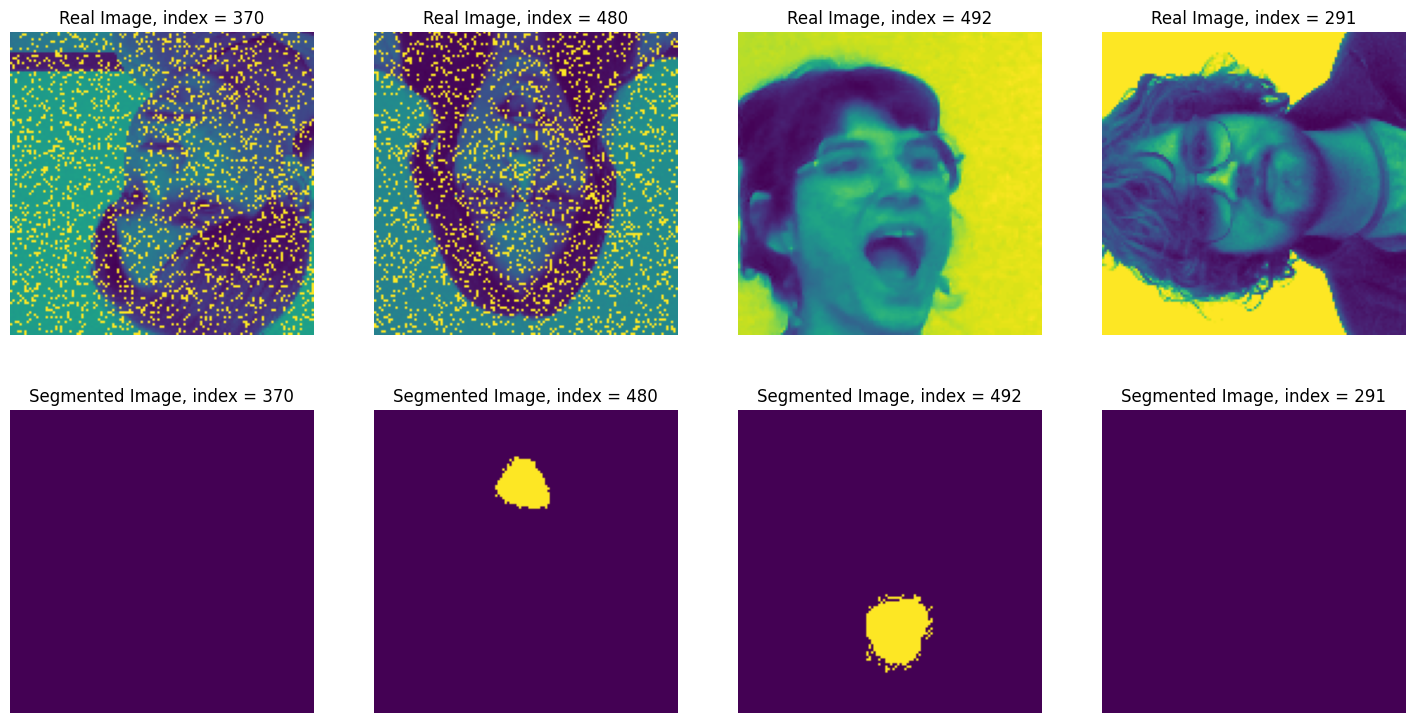

In [12]:
plot_images(images_train, masks_train,4)

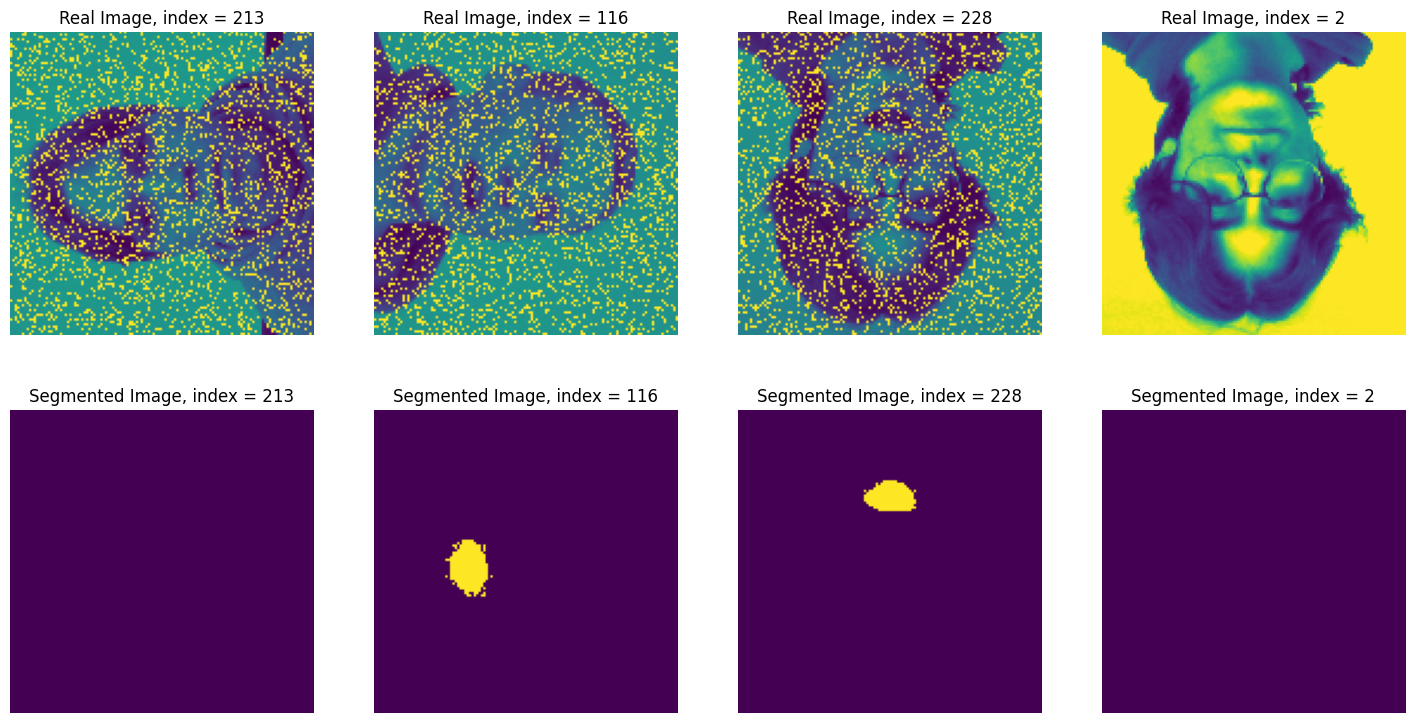

In [13]:
plot_images(images_val, masks_val,4)

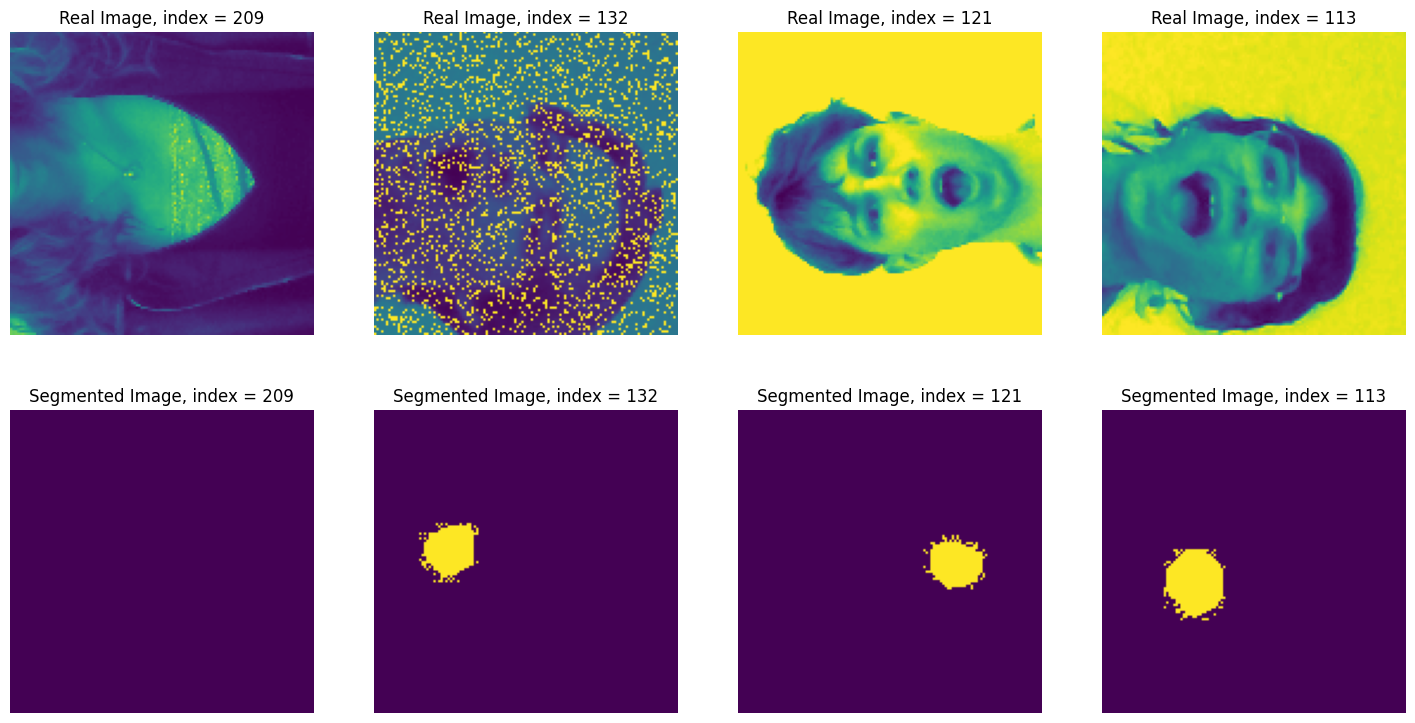

In [14]:
plot_images(images_test, masks_test,4)

In [15]:
#Converting the list of tensors into batches to efficiently train the model, computation-wise
batch_size = 5

train_data = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
train_data = train_data.batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
val_data = val_data.batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((images_test, masks_test))
test_data = test_data.batch(batch_size)

I0000 00:00:1744719556.428362    4724 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [16]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [17]:
unet = unet()
unet.compile(loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy', dice_coefficient])
unet.summary()

Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 25,808,193 (98.45 MB)

 Trainable params: 25,808,193 (98.45 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [19]:
unet_history = unet.fit(train_data,validation_data=[val_data],
                        epochs = 50, callbacks = [early_stopping])

Epoch 1/50


I0000 00:00:1744719560.066195    4855 service.cc:152] XLA service 0x7fe5c80024b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744719560.066244    4855 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-04-15 14:19:20.149811: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744719560.747294    4855 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744719571.731020    4855 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9539 - dice_coefficient: 0.0312 - loss: 0.1812

2025-04-15 14:19:52.888298: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 8 bytes spill stores, 8 bytes spill loads



176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.9541 - dice_coefficient: 0.0313 - loss: 0.1807 - val_accuracy: 0.9783 - val_dice_coefficient: 0.0527 - val_loss: 0.1336
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9793 - dice_coefficient: 0.0408 - loss: 0.1071 - val_accuracy: 0.9783 - val_dice_coefficient: 0.0541 - val_loss: 0.1317
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9793 - dice_coefficient: 0.0431 - loss: 0.1032 - val_accuracy: 0.9783 - val_dice_coefficient: 0.0534 - val_loss: 0.1228
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9793 - dice_coefficient: 0.0414 - loss: 0.0998 - val_accuracy: 0.9783 - val_dice_coefficient: 0.0499 - val_loss: 0.1046
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9792 - dice_coefficient: 0.0399 - loss: 0.1028 - val_accuracy: 0.9783 - val_dice_coefficient: 0.0435 - val_loss: 0.1058
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.97

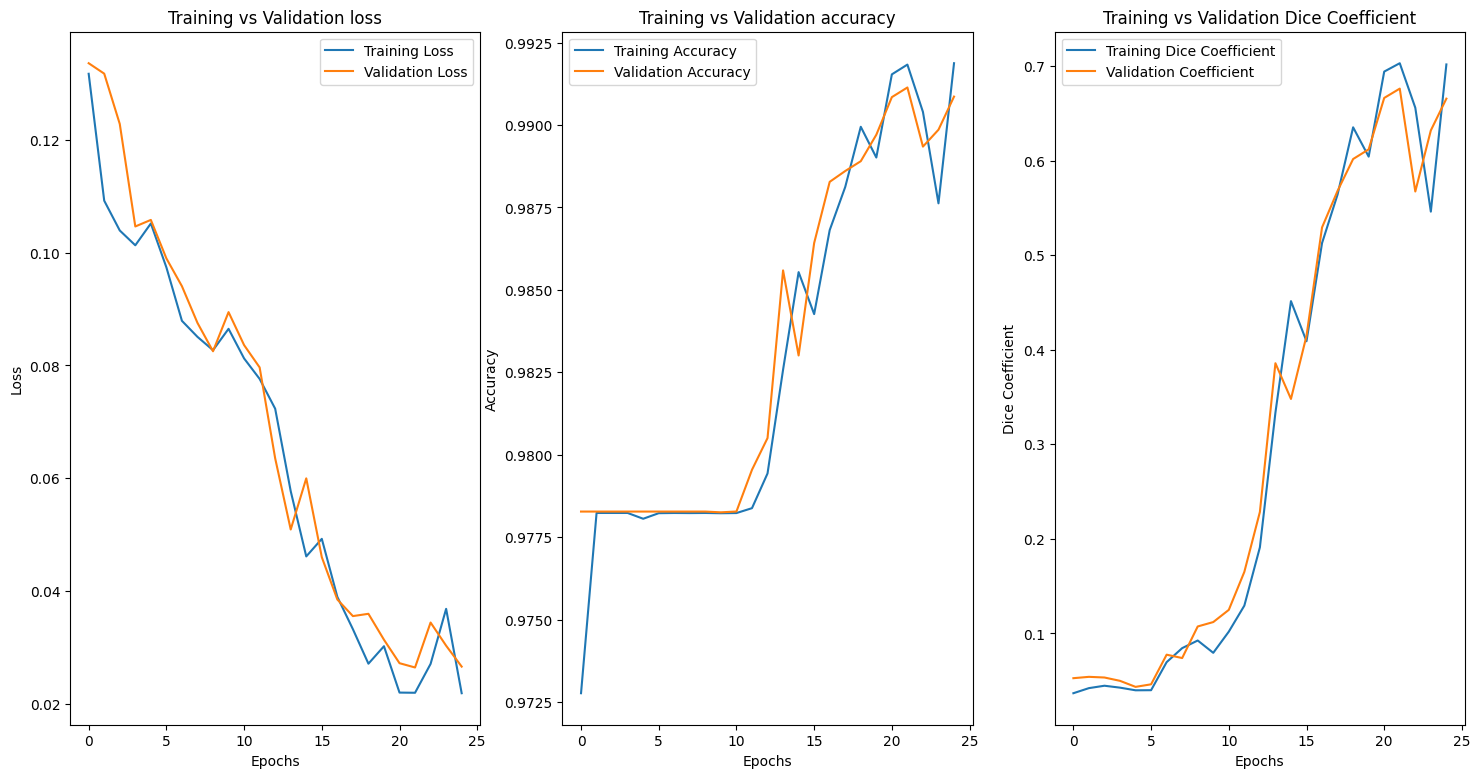

In [20]:
#Plotting the loss and accuracy during training and validation
plt.figure(figsize = (18, 9))
plt.subplot(1,3,1)
plt.plot(unet_history.history['loss'])
plt.plot(unet_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.subplot(1,3,2)
plt.plot(unet_history.history['accuracy'])
plt.plot(unet_history.history['val_accuracy'])
plt.title('Training vs Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.subplot(1,3,3)
plt.plot(unet_history.history['dice_coefficient'])
plt.plot(unet_history.history['val_dice_coefficient'])
plt.title('Training vs Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(['Training Dice Coefficient', 'Validation Coefficient'])

In [21]:
conv_layers = [layer for layer in unet.layers if 'conv' in layer.name.lower()]
layer_outputs = [layer.output for layer in unet.layers if 'conv' in layer.name.lower()]
activation_model = Model(inputs=unet.input, outputs=layer_outputs)
test_img = images_test[125]
test_img = tf.expand_dims(test_img, axis = 0)
test_img = tf.expand_dims(test_img, axis = -1)
activations = activation_model.predict(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [22]:
def plot_feature_maps(activation, layer_name, num_maps=6):
    num_maps = min(num_maps, activation.shape[-1])  # Make sure we don't exceed available channels
    fig, axes = plt.subplots(1, num_maps, figsize=(20, 8))
    fig.suptitle(f'Layer: {layer_name}', fontsize=16)

    # If there's only one map, wrap axes in a list
    if num_maps == 1:
        axes = [axes]

    for i in range(num_maps):
        axes[i].imshow(activation[0, :, :, i], cmap='viridis')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

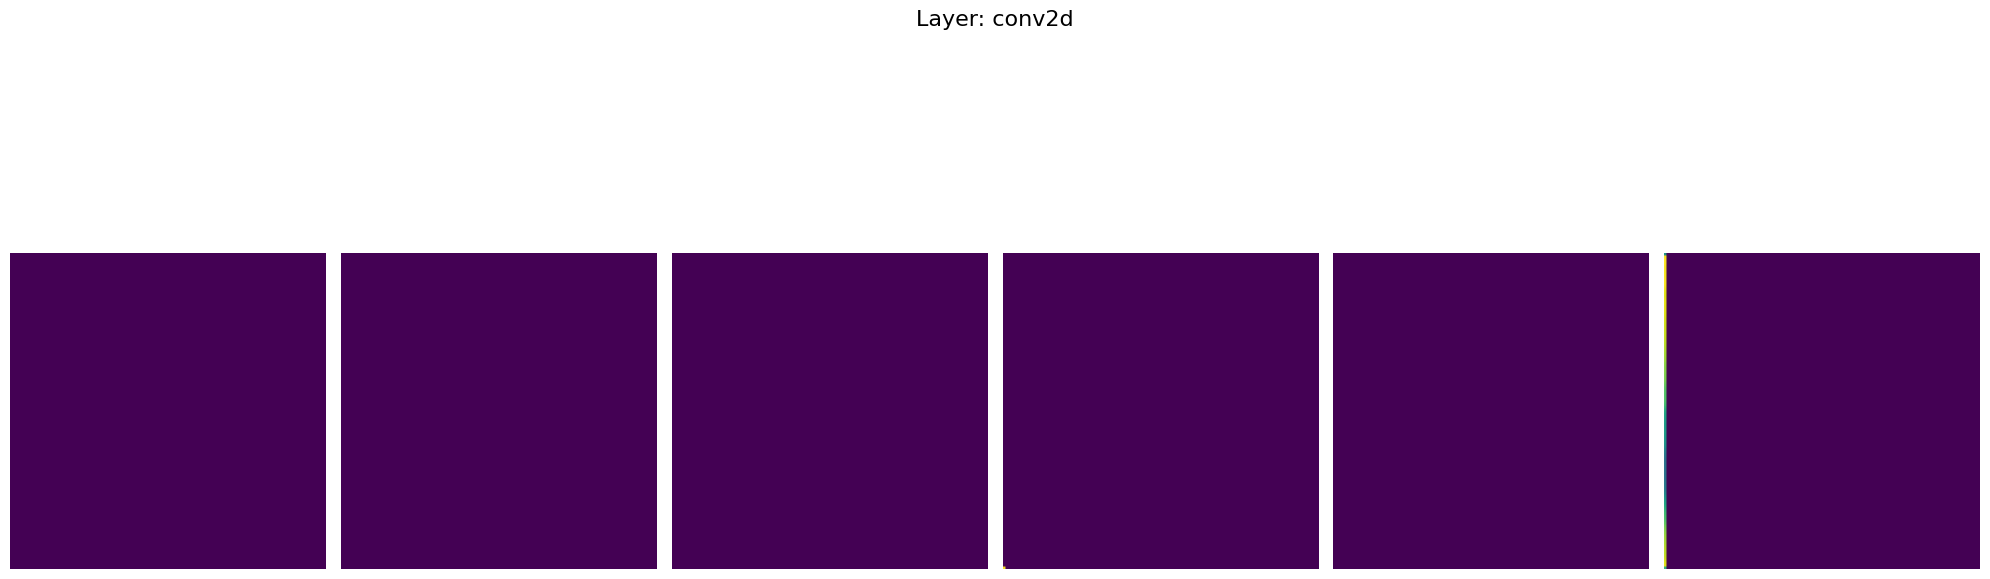

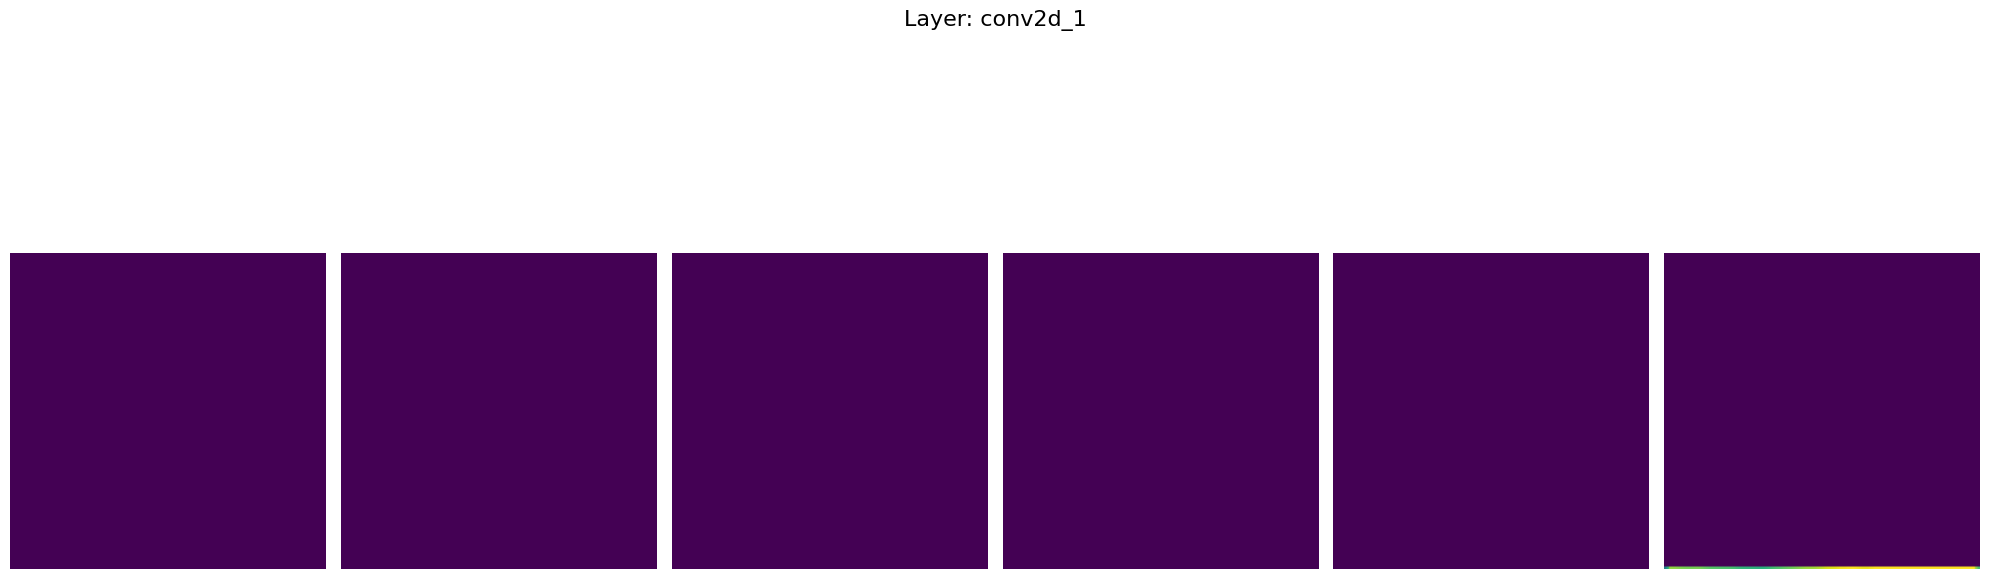

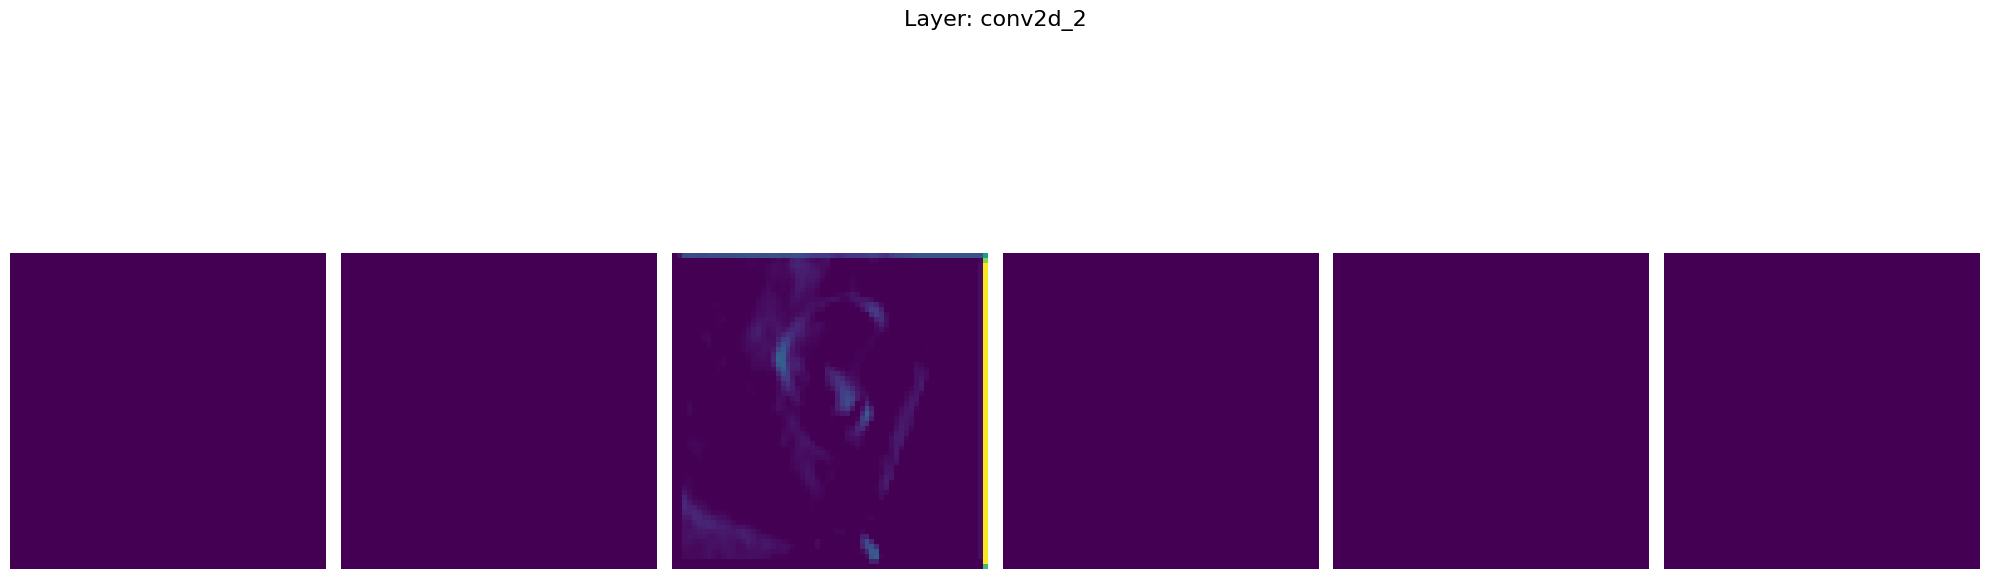

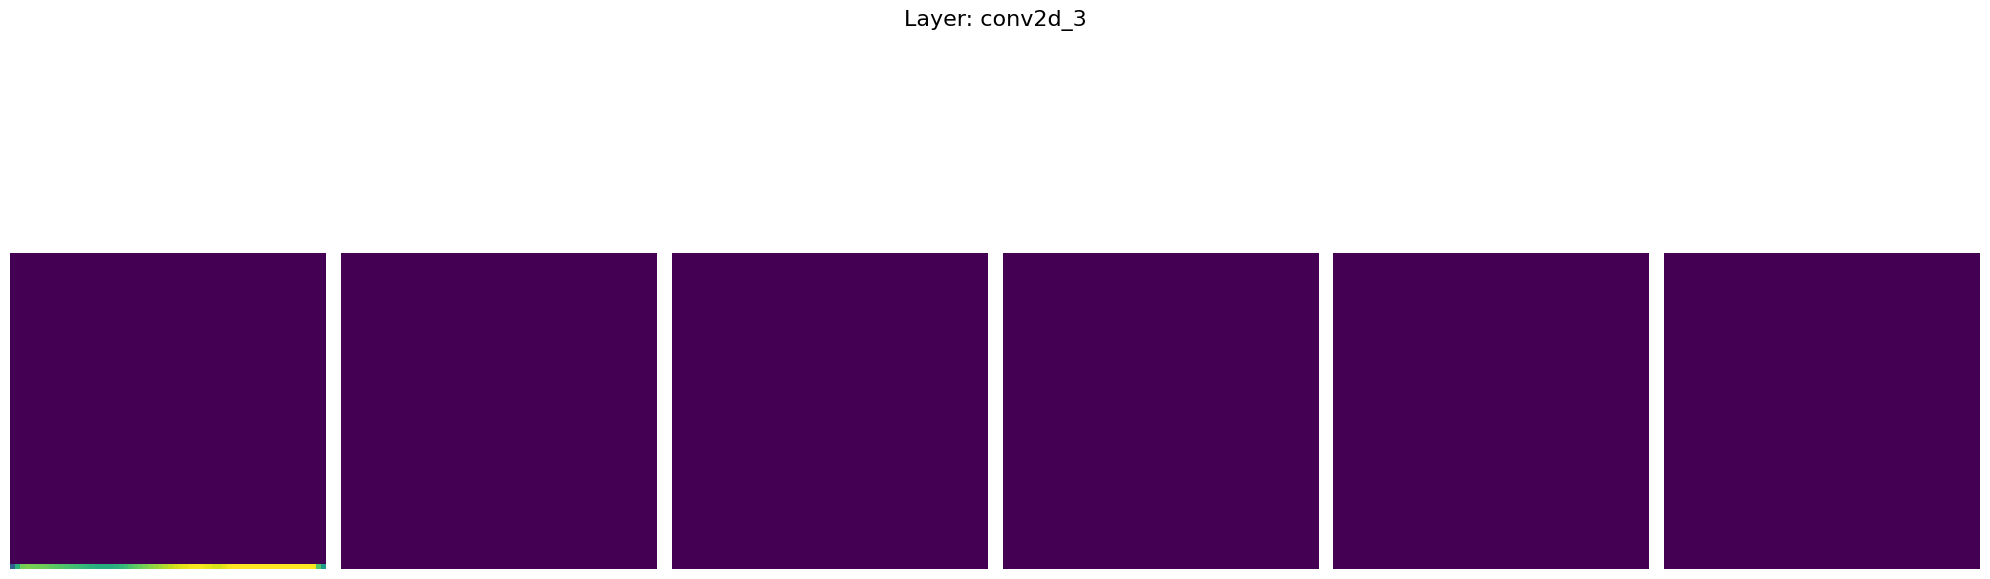

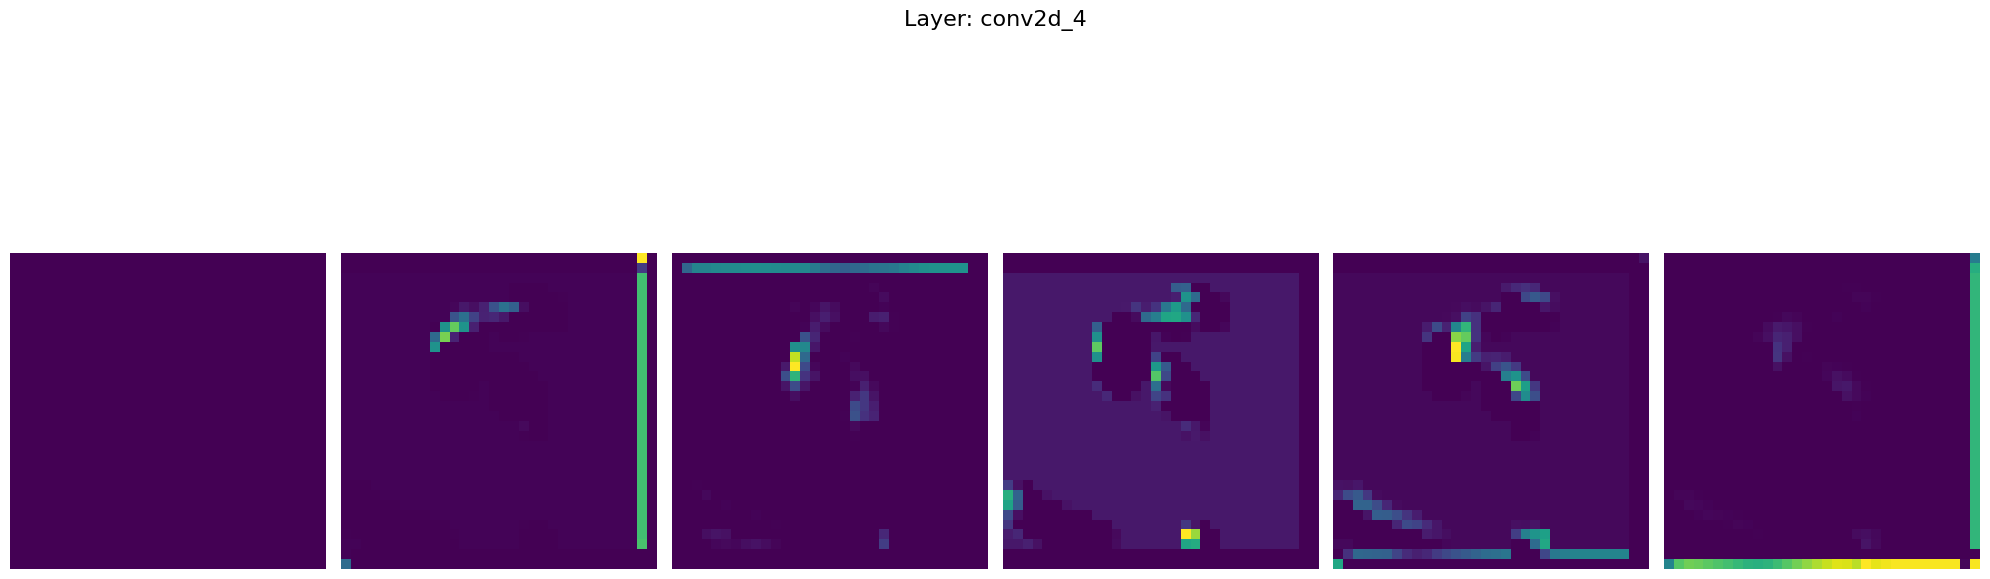

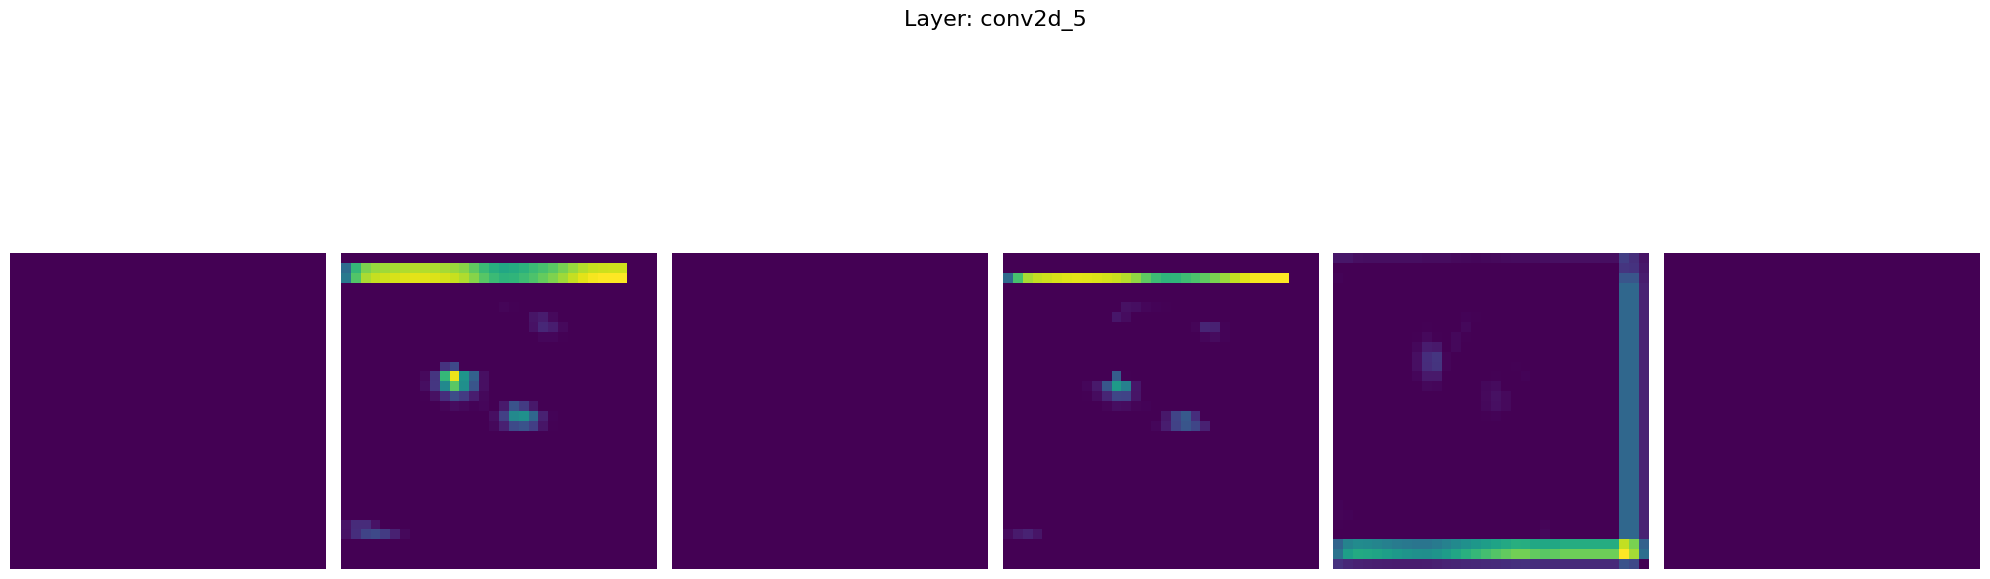

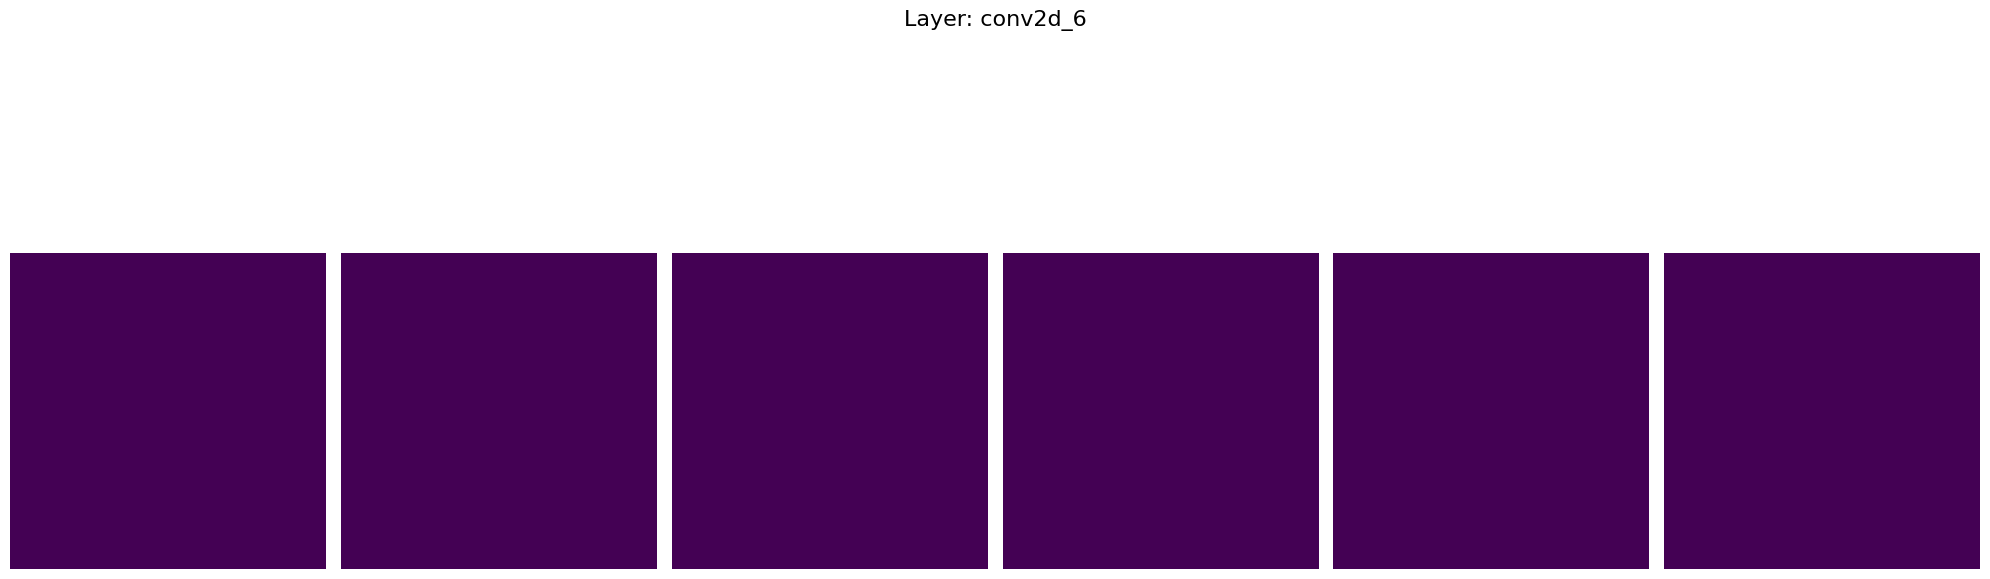

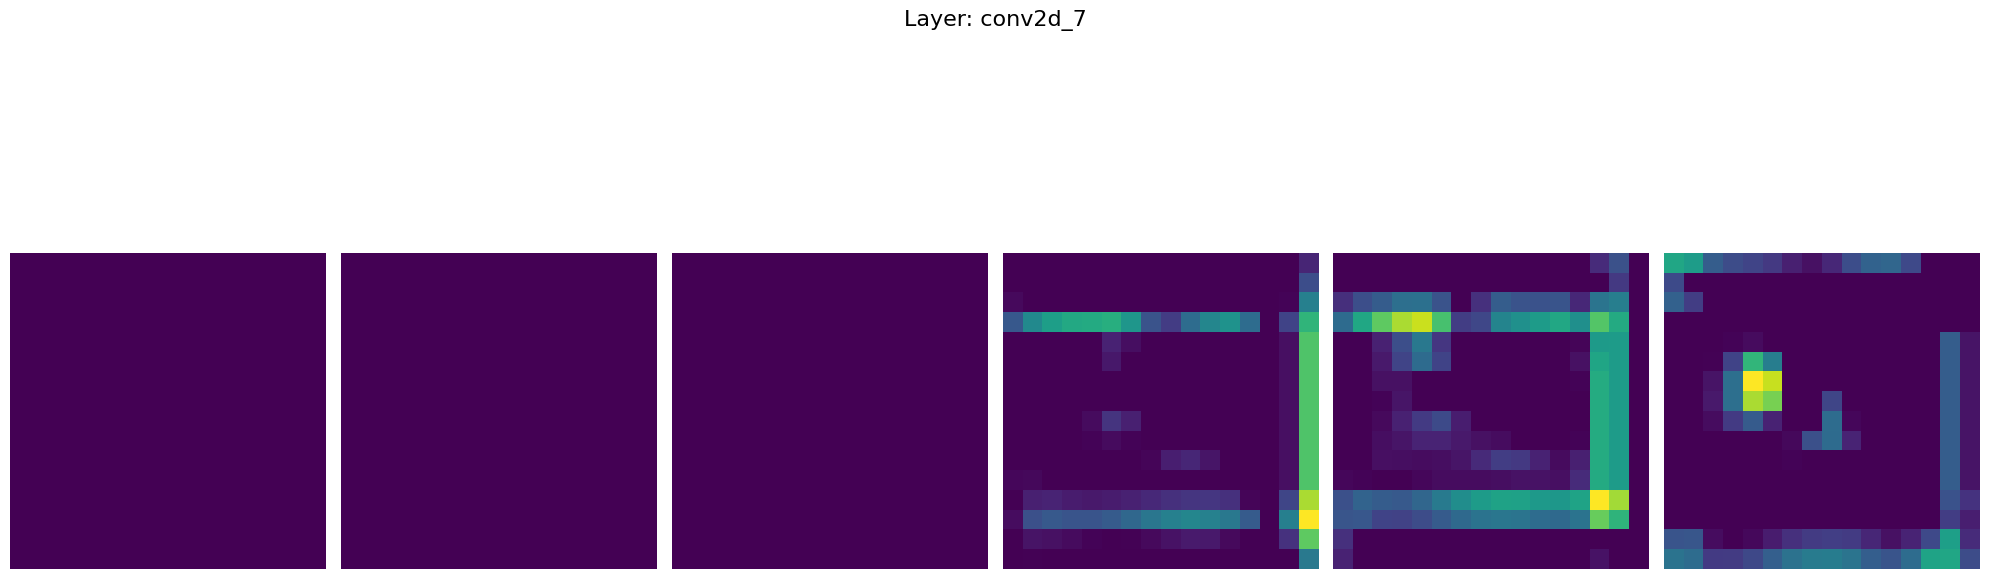

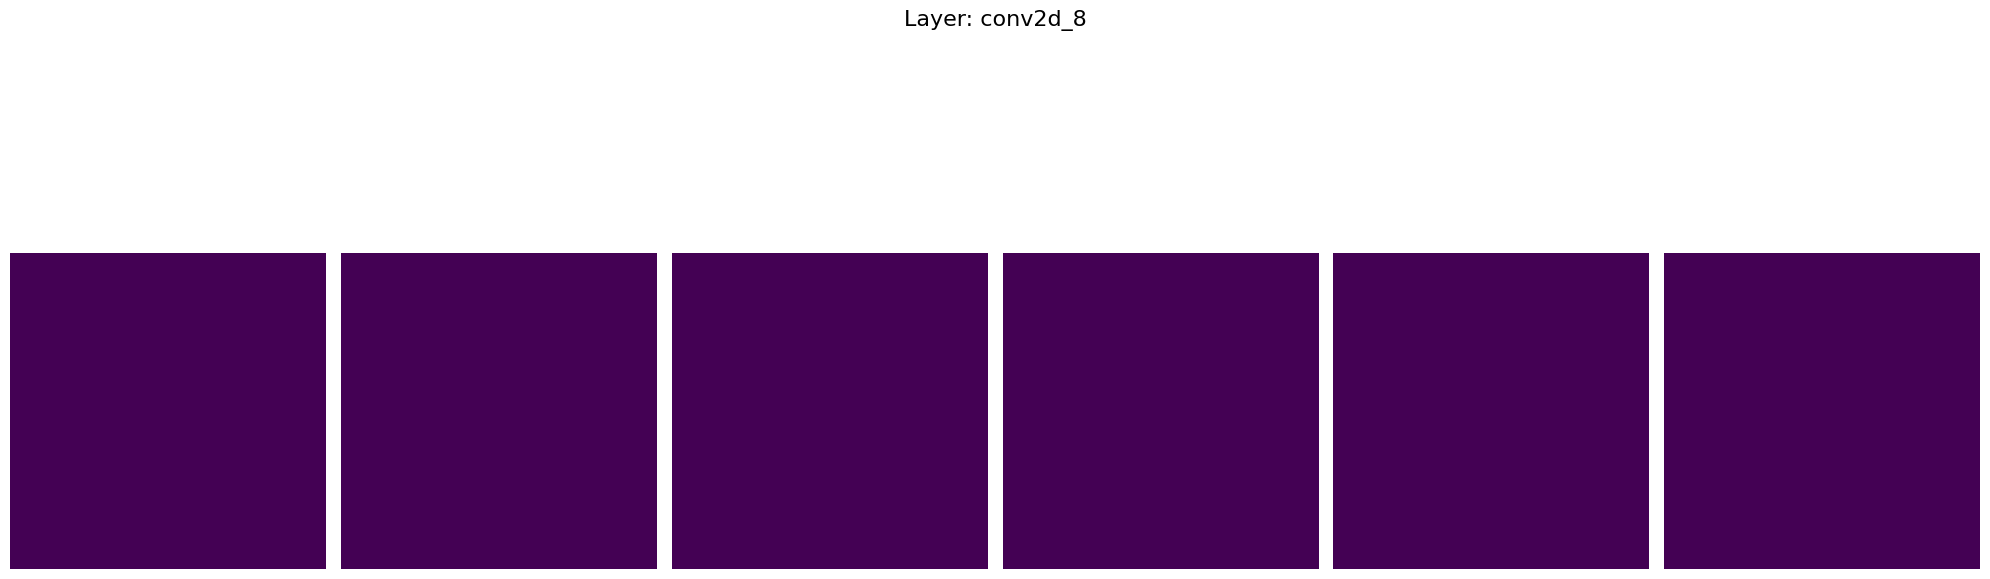

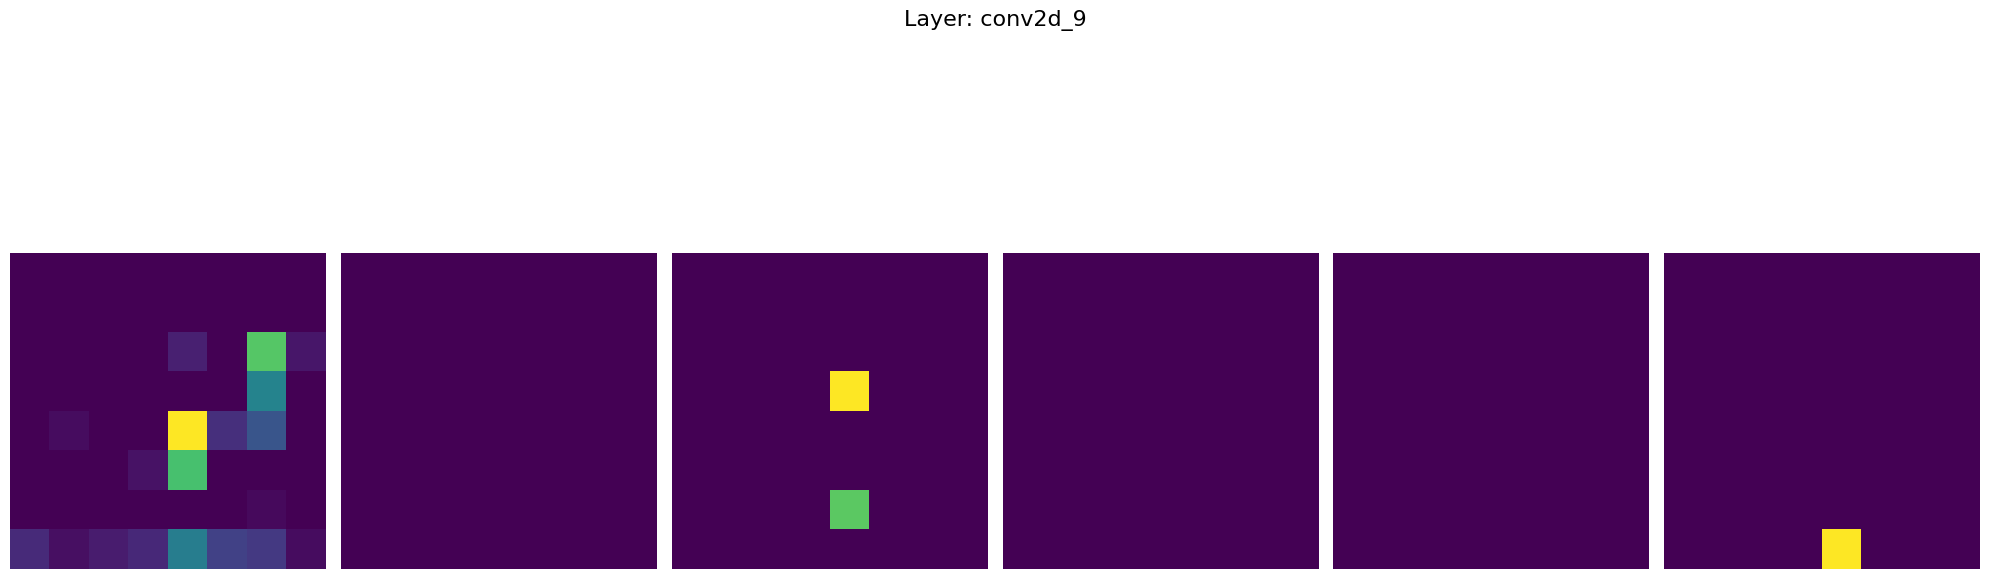

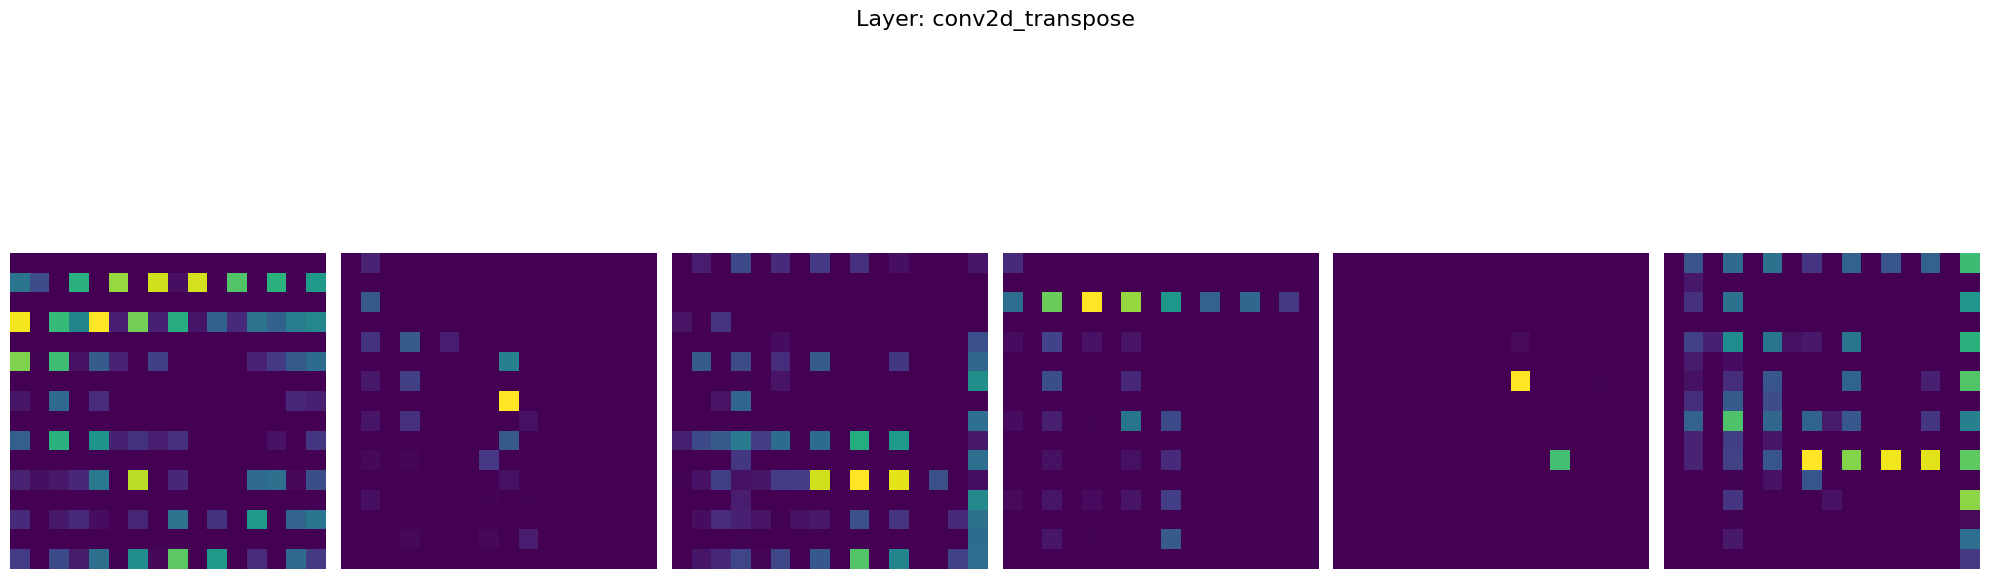

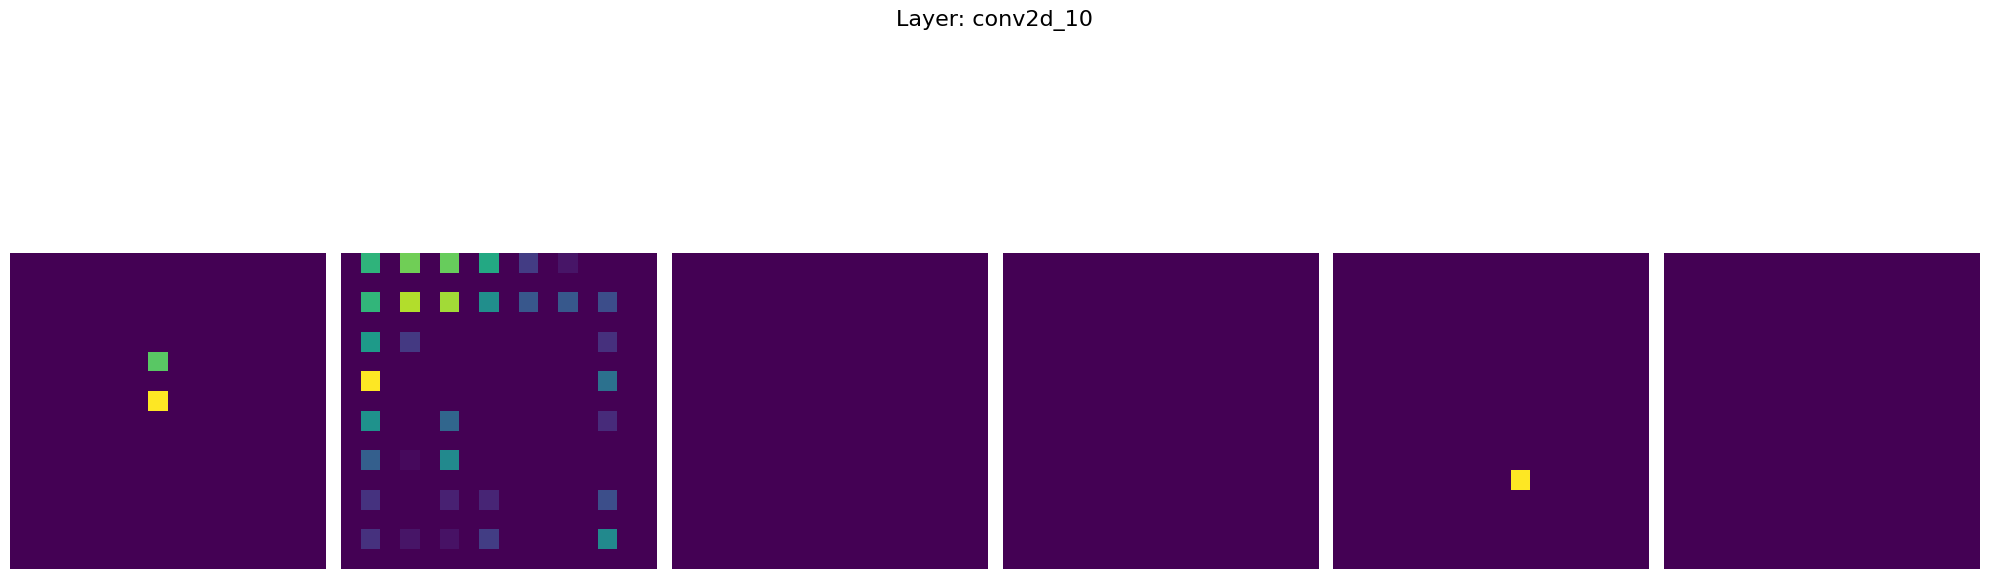

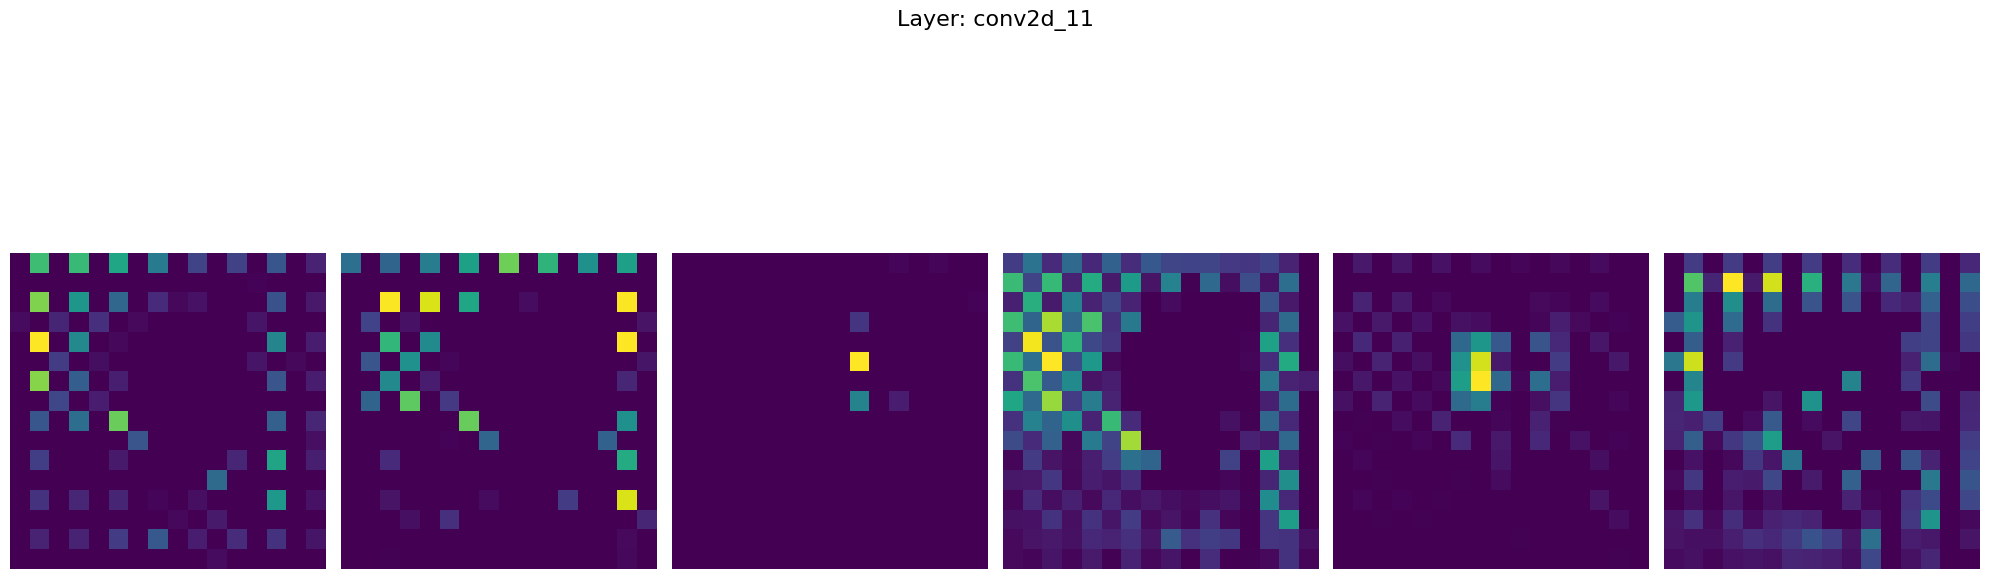

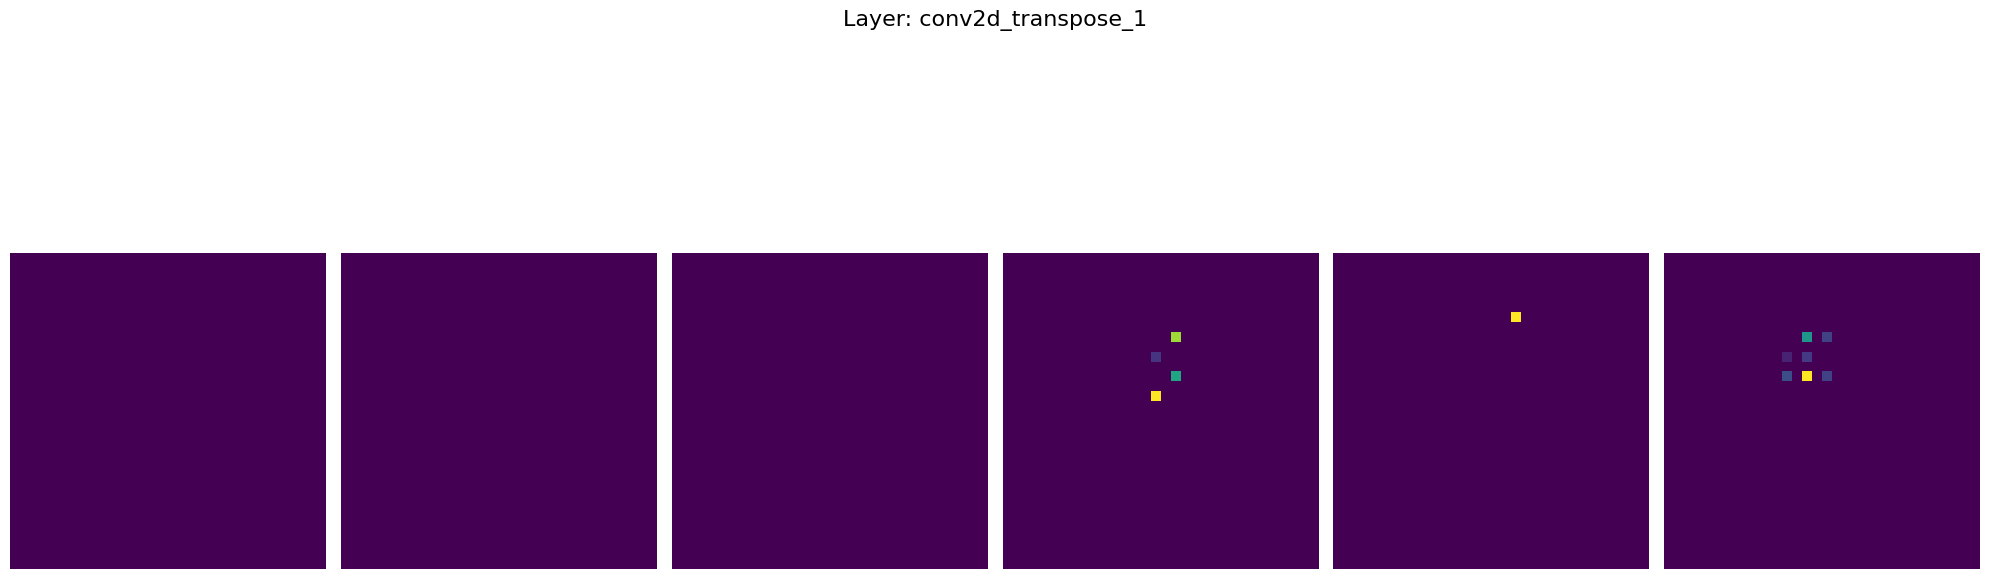

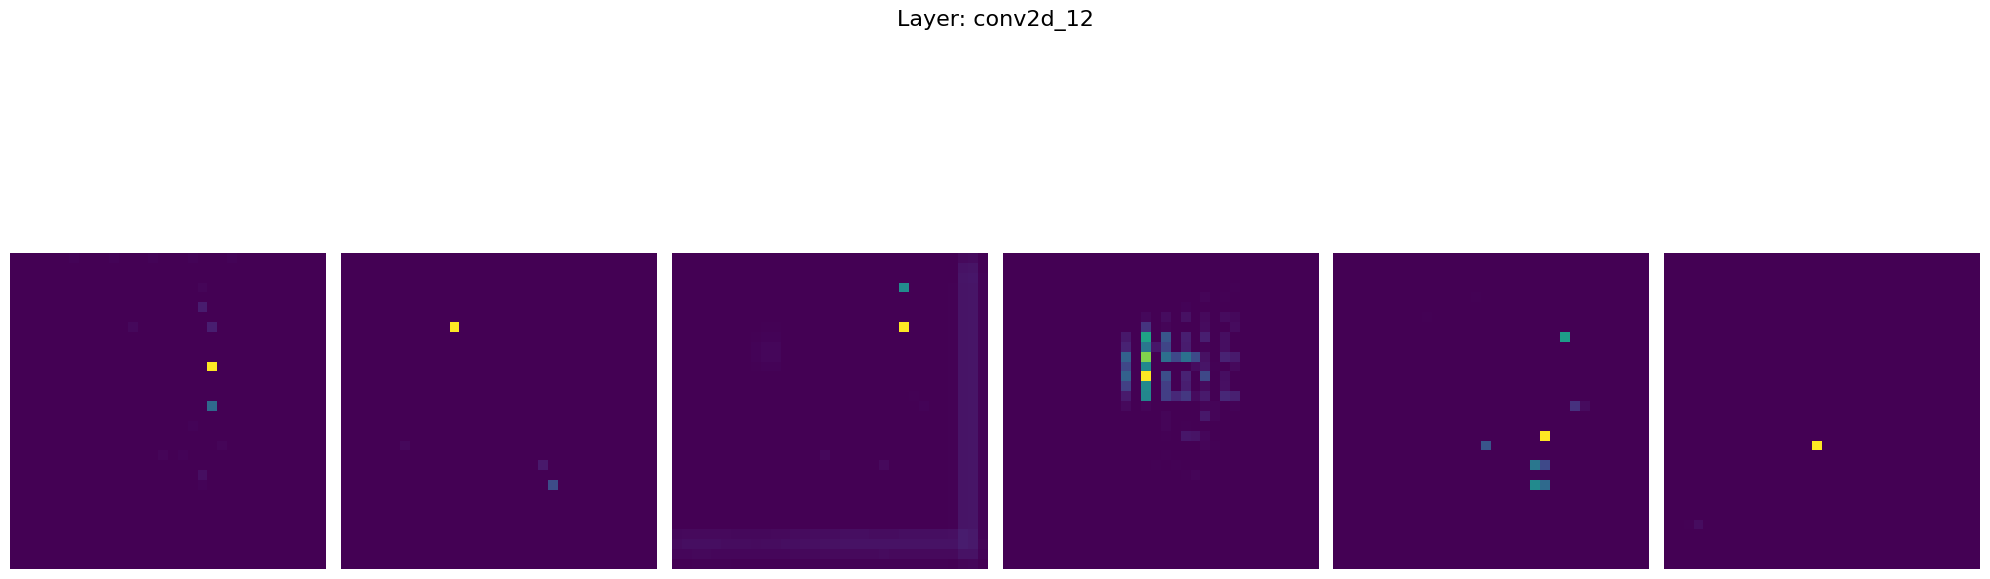

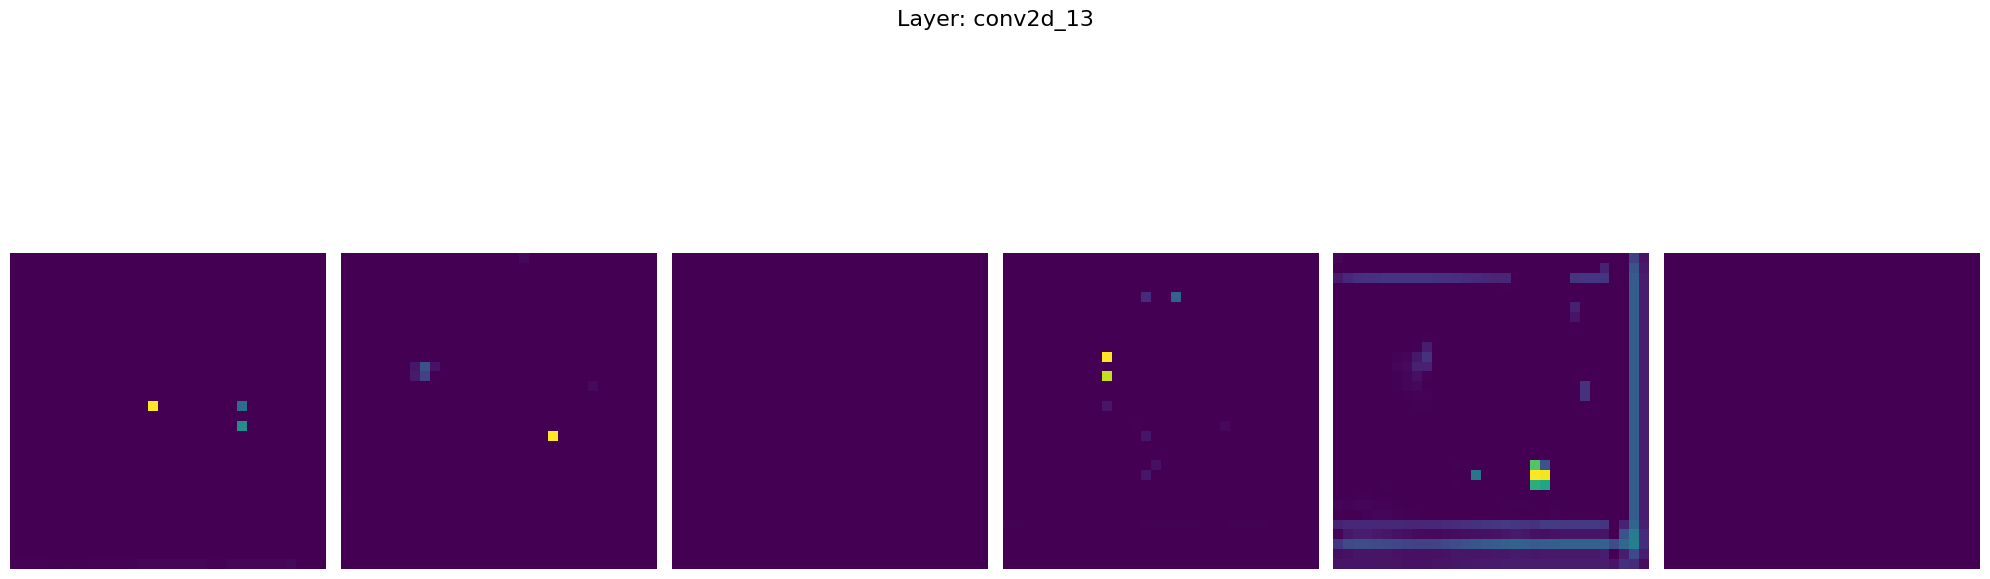

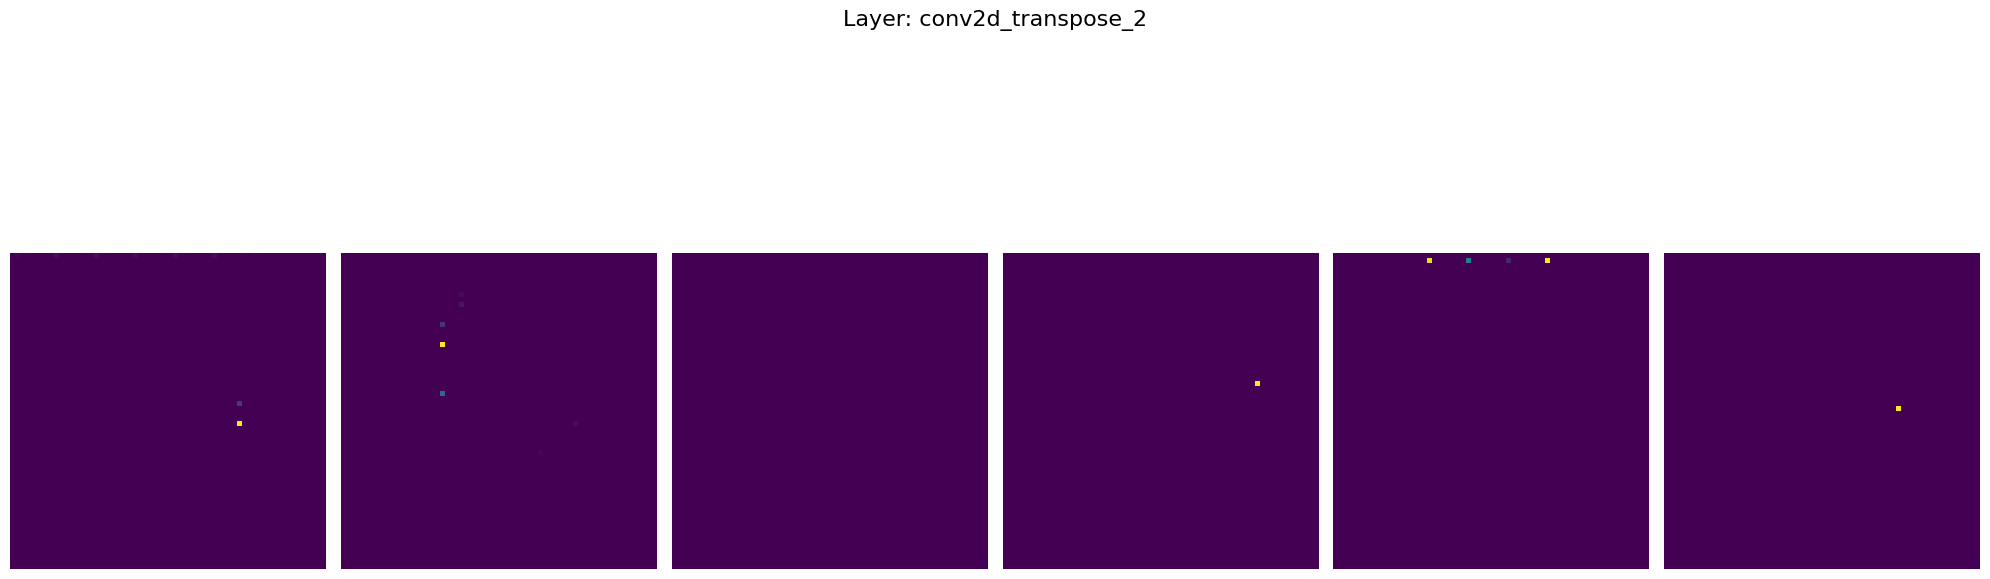

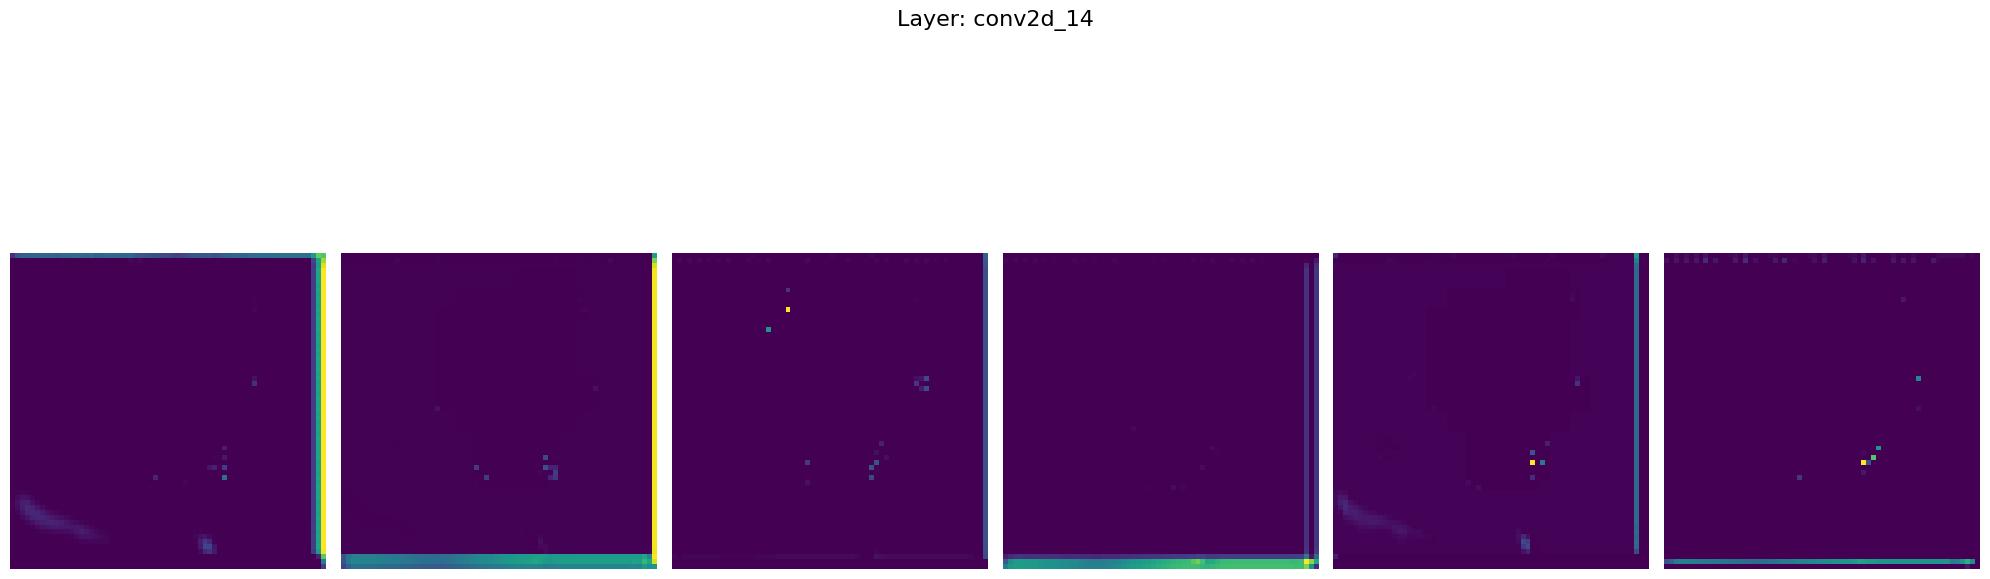

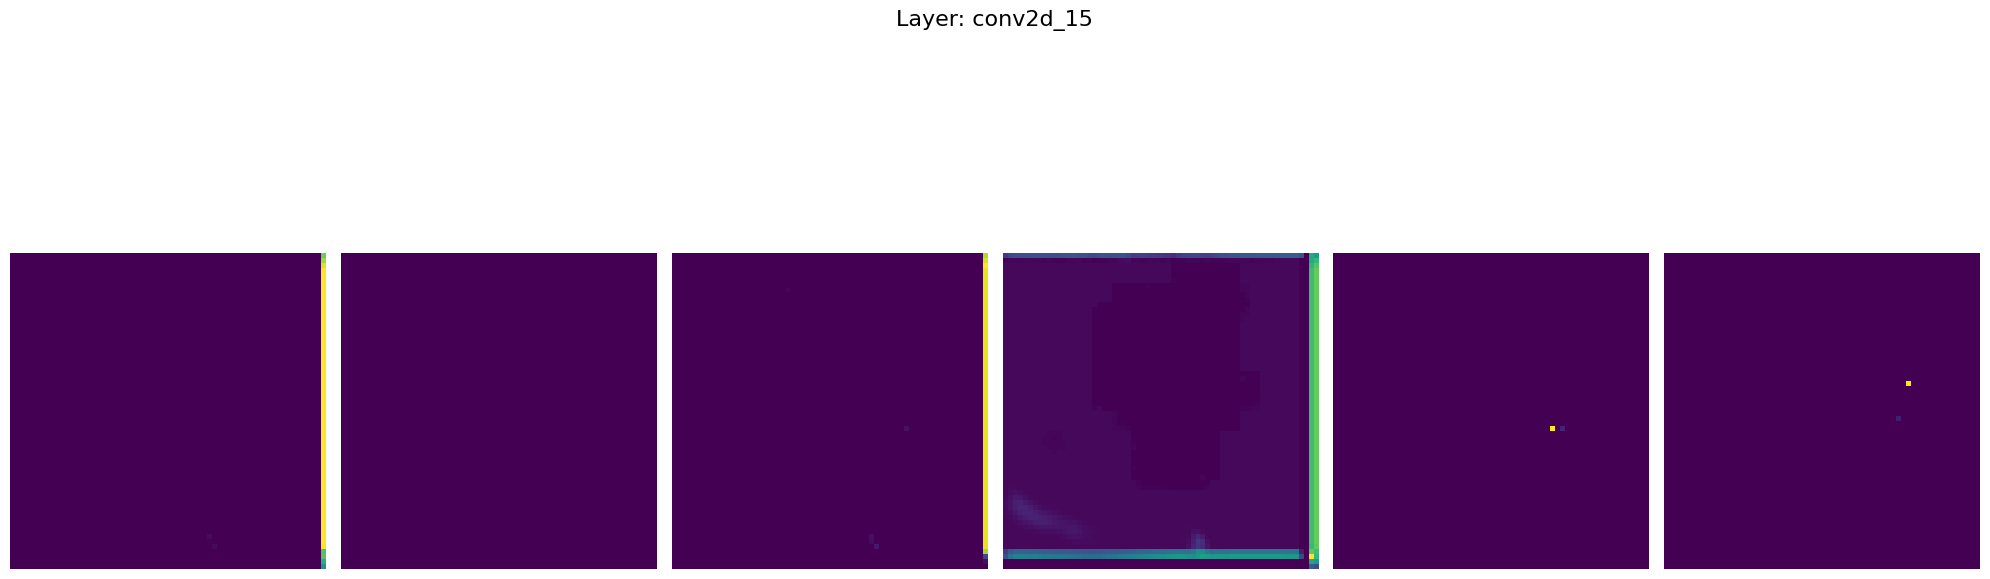

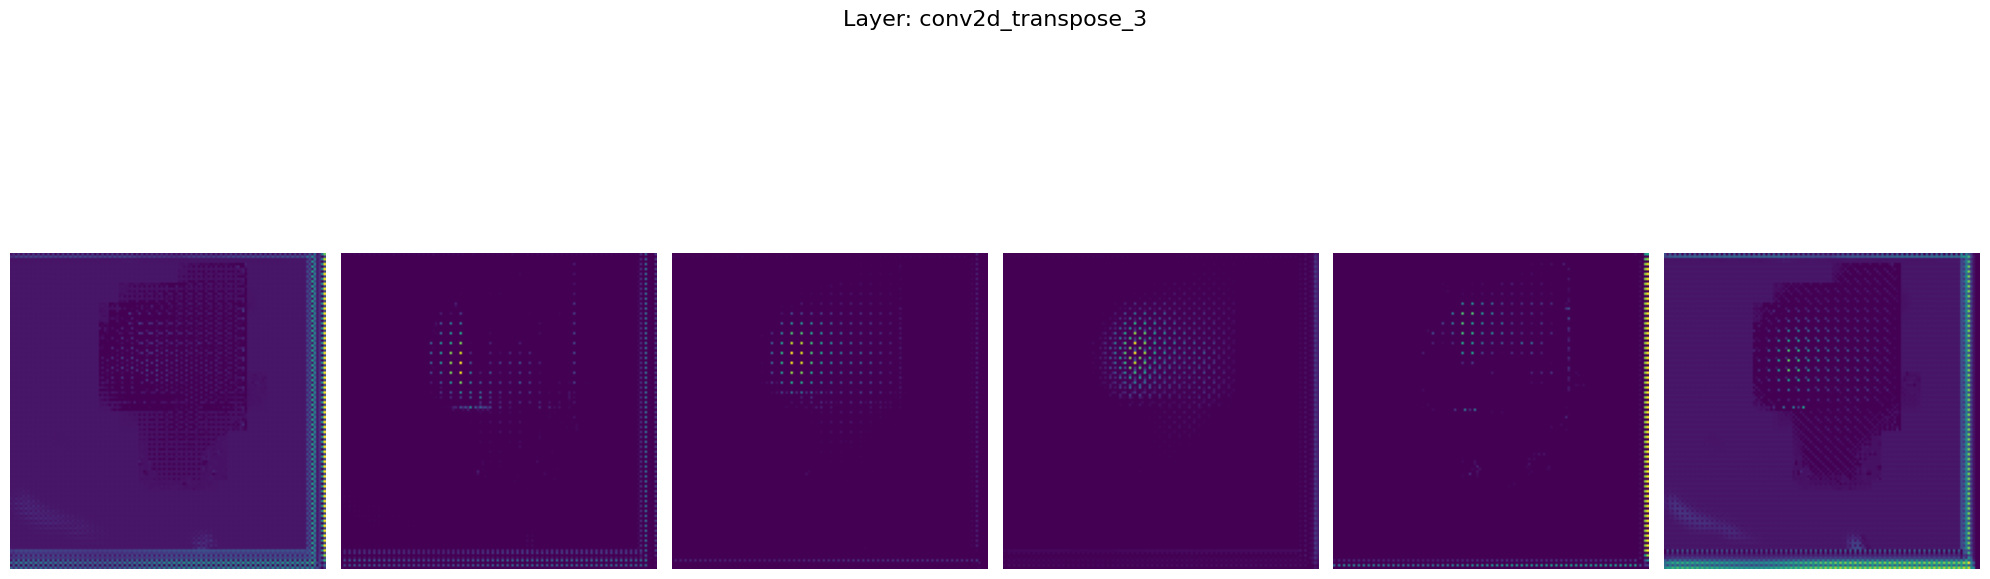

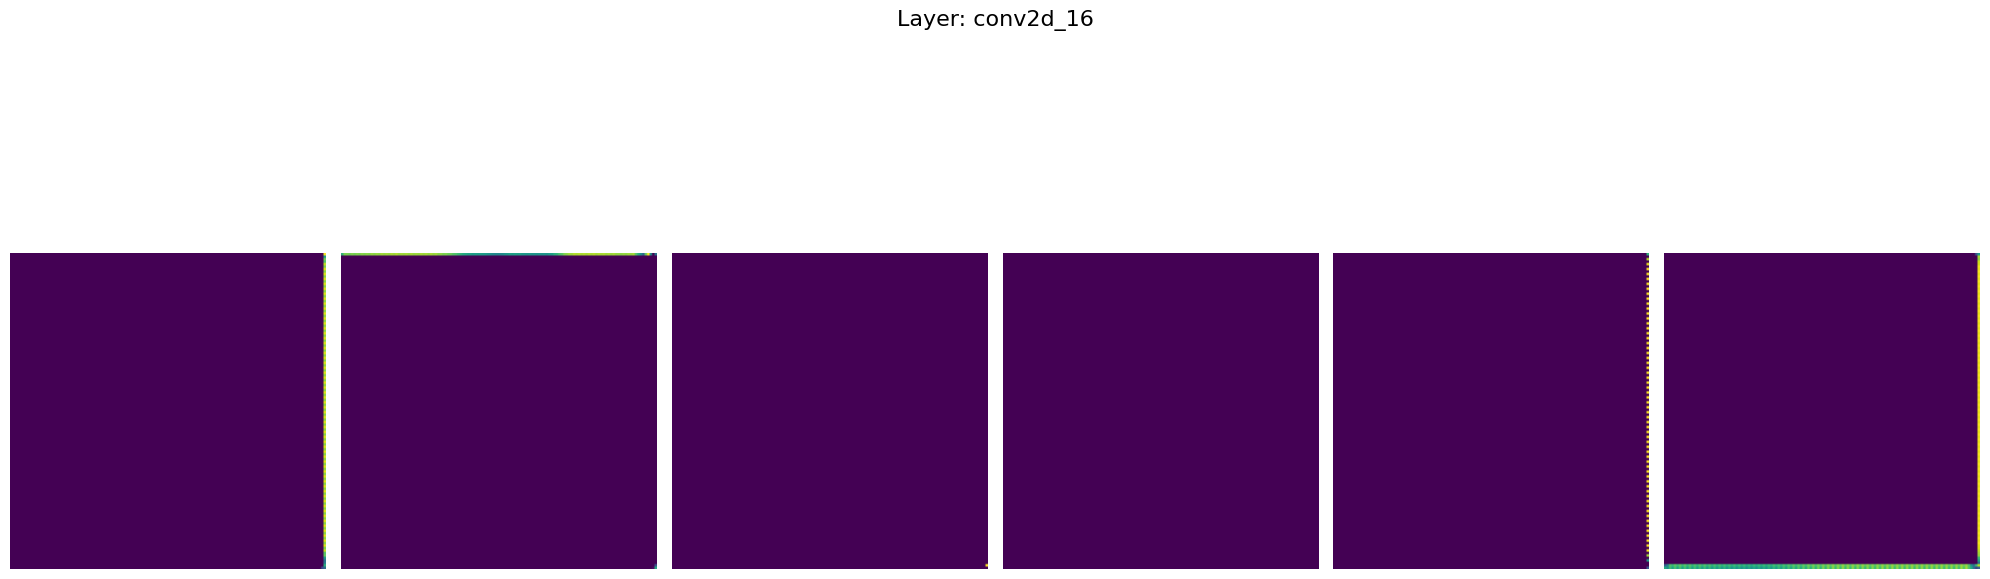

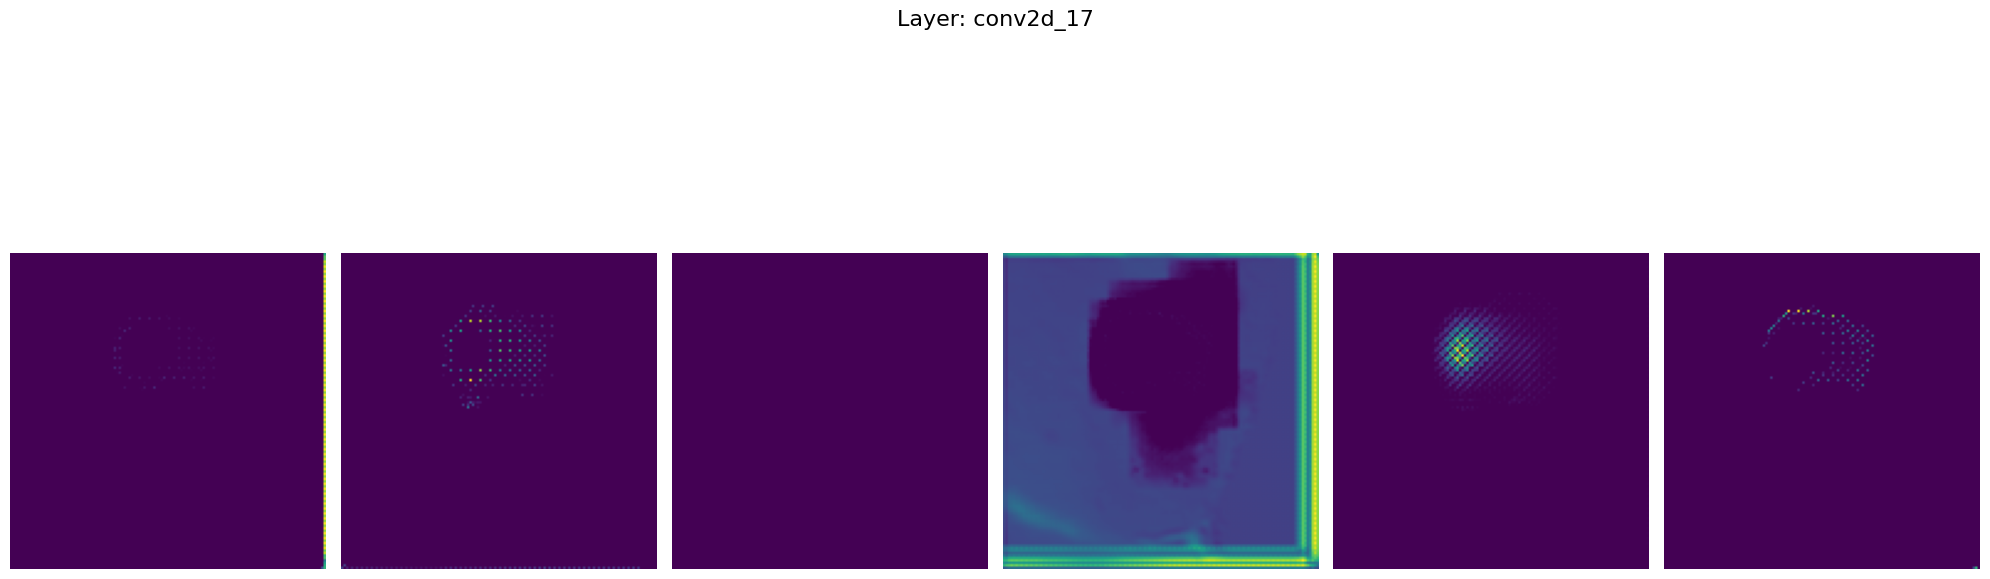

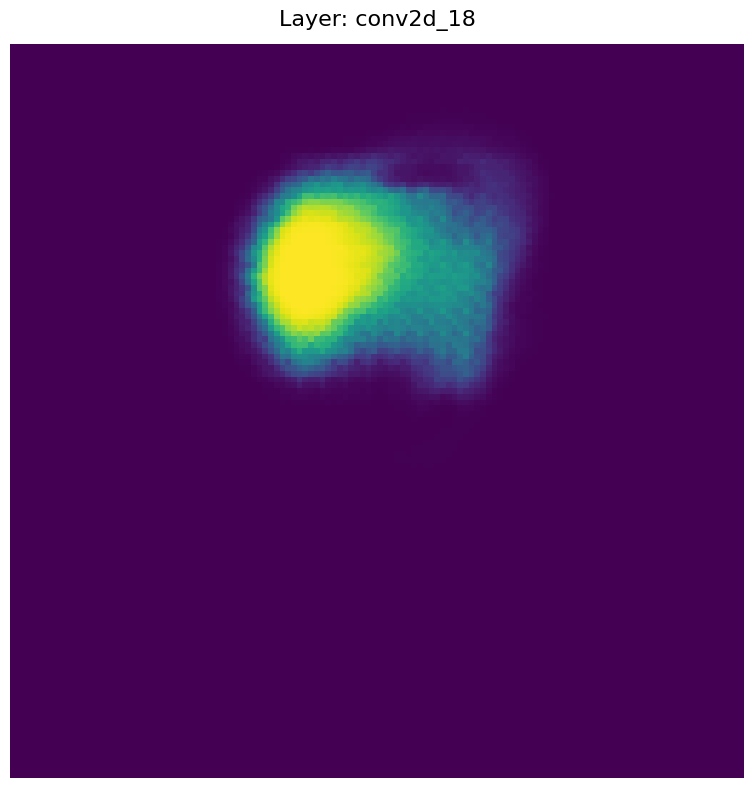

In [23]:
for layer, activation in zip(conv_layers, activations):
    plot_feature_maps(activation, layer.name)

In [24]:
unet.evaluate(test_data)

59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9922 - dice_coefficient: 0.6474 - loss: 0.0242


[0.02583717741072178, 0.9913548231124878, 0.6764386296272278]

In [25]:
#Function to plot the predictions with orginal image, original mask and predicted mask
def plot_preds(idx):
    plt.figure(figsize = (15, 15))
    test_img = images_test[idx]
    test_img = tf.expand_dims(test_img, axis = 0)
    test_img = tf.expand_dims(test_img, axis = -1)
    pred = unet.predict(test_img)
    print(np.unique(pred))
    pred = pred.squeeze()
    print(np.unique(pred))
    thresh = pred > 0.5
    plt.subplot(1,3,1)
    plt.imshow(images_test[idx])
    plt.title(f'Original Image {idx}')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(masks_test[idx])
    plt.title('Actual Mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(thresh)
    plt.title('Predicted Mask')
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
[8.0122589e-11 8.0645872e-11 8.4022393e-11 ... 1.2734405e-03 1.3101028e-03
 1.3296448e-03]
[8.0122589e-11 8.0645872e-11 8.4022393e-11 ... 1.2734405e-03 1.3101028e-03
 1.3296448e-03]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[1.4232916e-11 1.4565659e-11 1.4613021e-11 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[1.4232916e-11 1.4565659e-11 1.4613021e-11 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[1.4940545e-14 1.5467084e-14 1.8917659e-14 ... 3.0868761e-03 3.1792694e-03
 3.2024195e-03]
[1.4940545e-14 1.5467084e-14 1.8917659e-14 ... 3.0868761e-03 3.1792694e-03
 3.2024195e-03]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[5.2098794e-11 5.2348414e-11 5.3336311e-11 ... 9.9810362e-01 9.9837542e-01
 9.9839085e-01]
[5.2098794e-11 5.2348414e-11 5.3336311e-11 ... 9.9810362e-01 9.9837542e-01
 9.9839085e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[2.7247656e-11 2.7342040e-11 2.7463981e-11 ... 9.9999166e-01 9.9999201e-01
 9.999

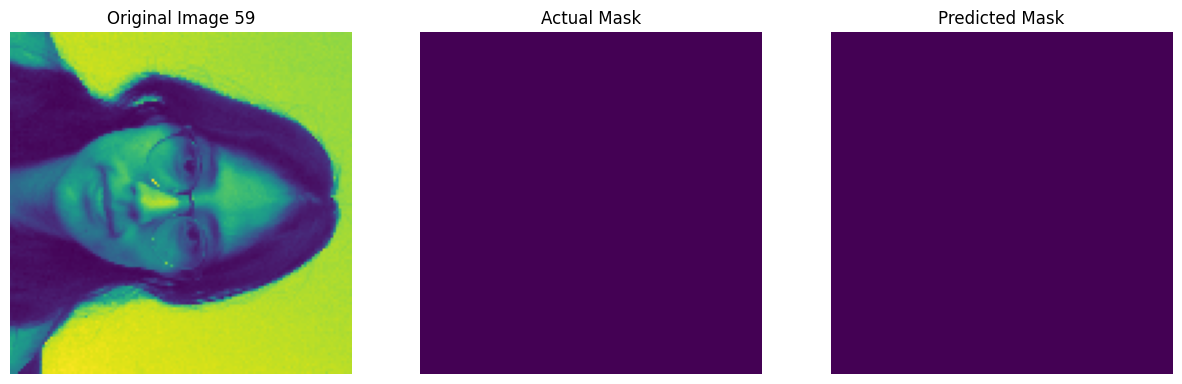

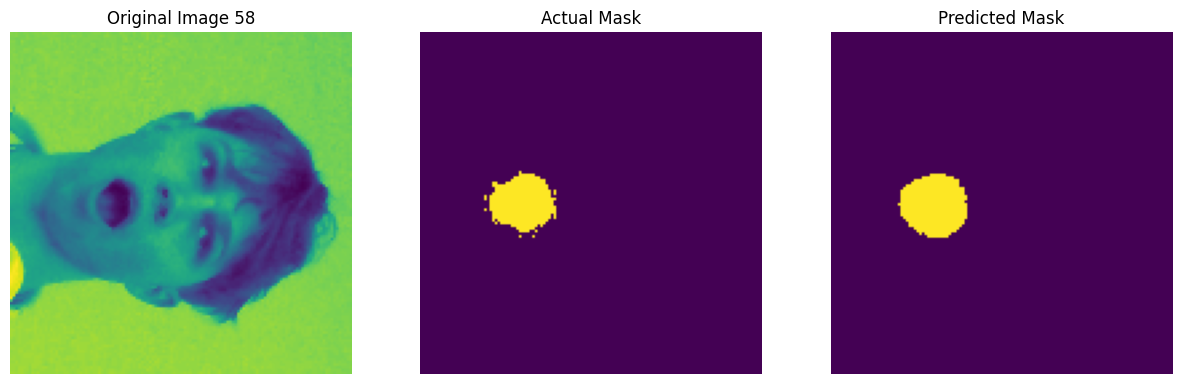

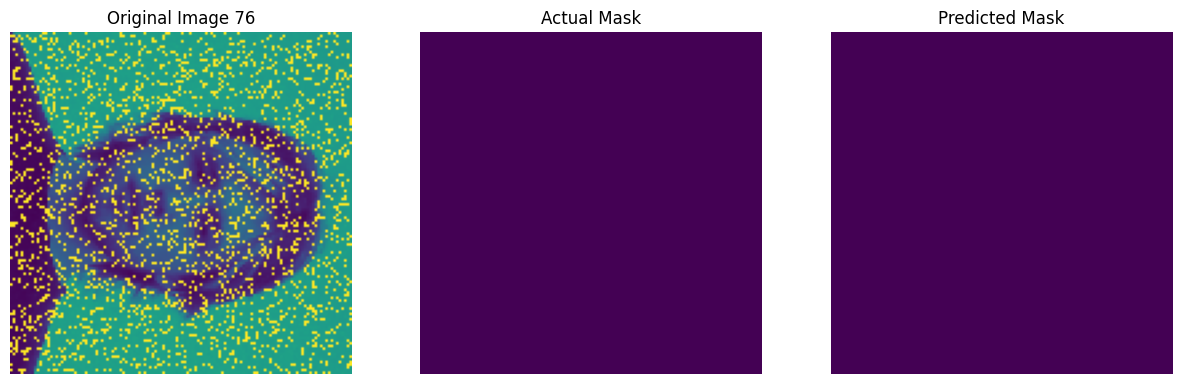

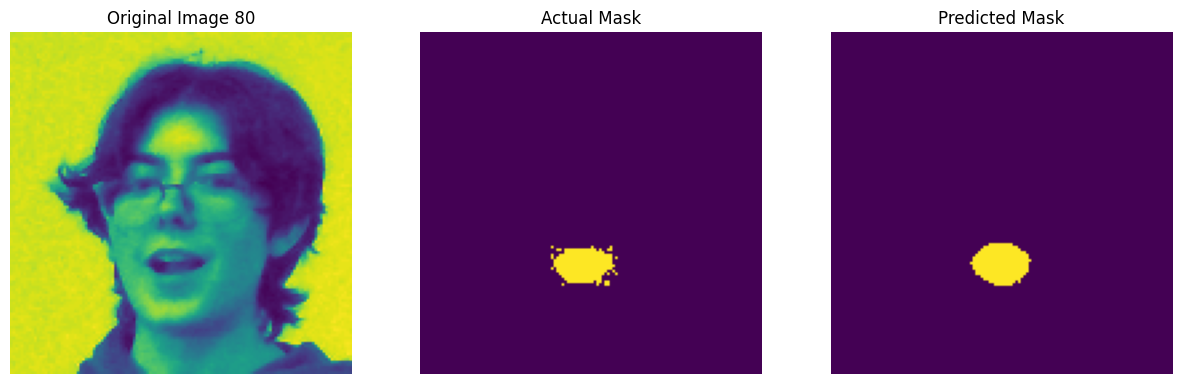

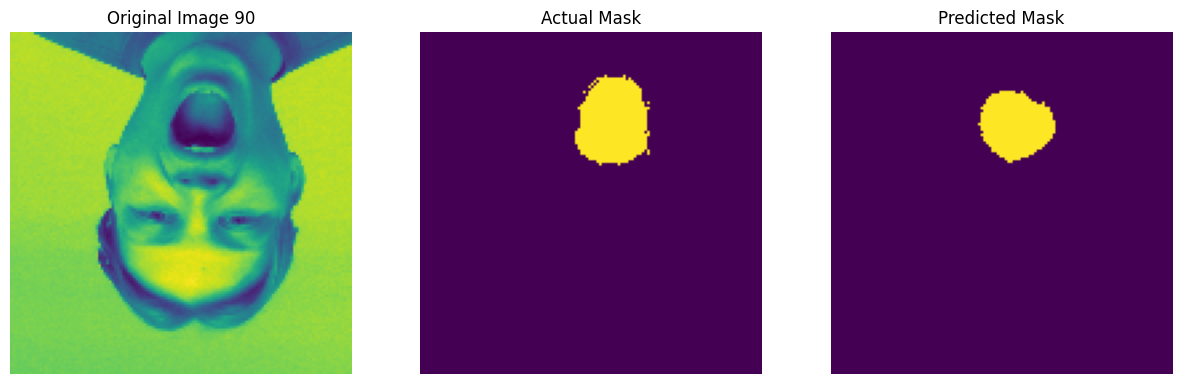

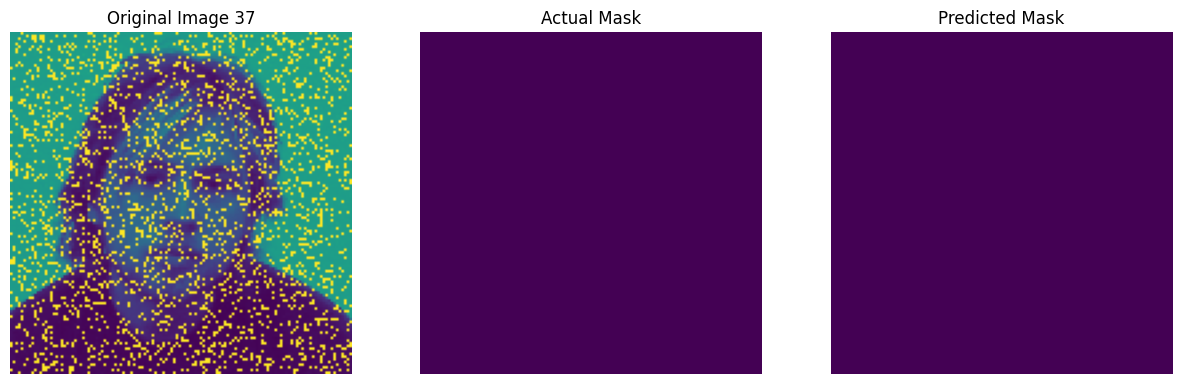

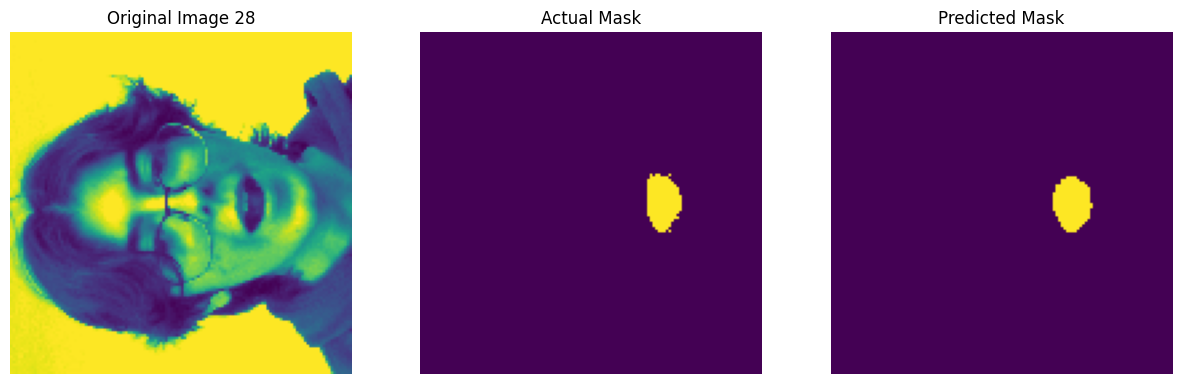

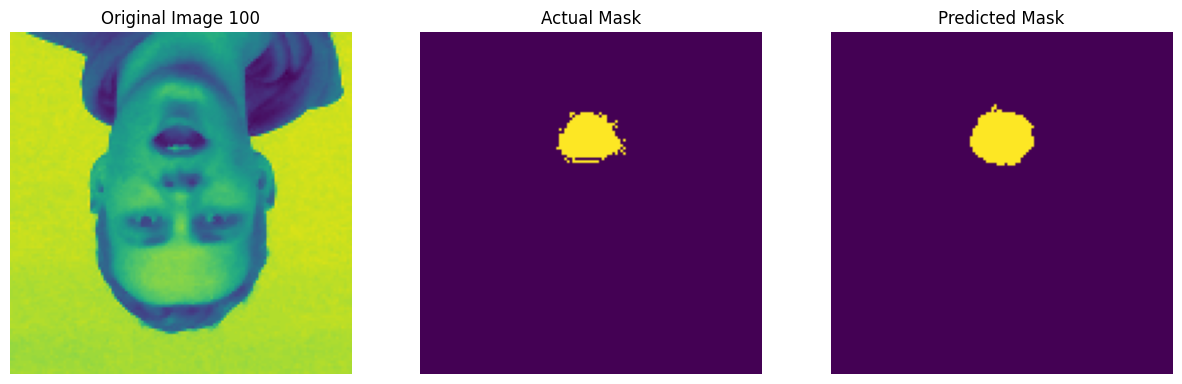

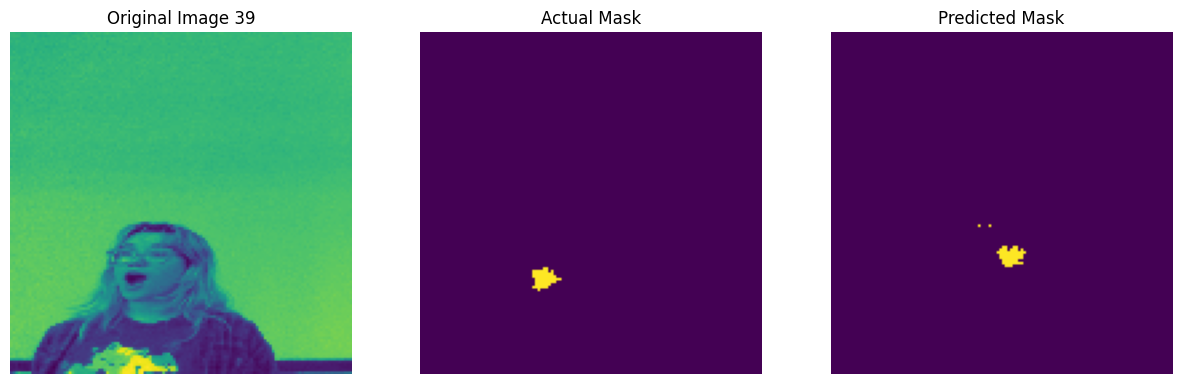

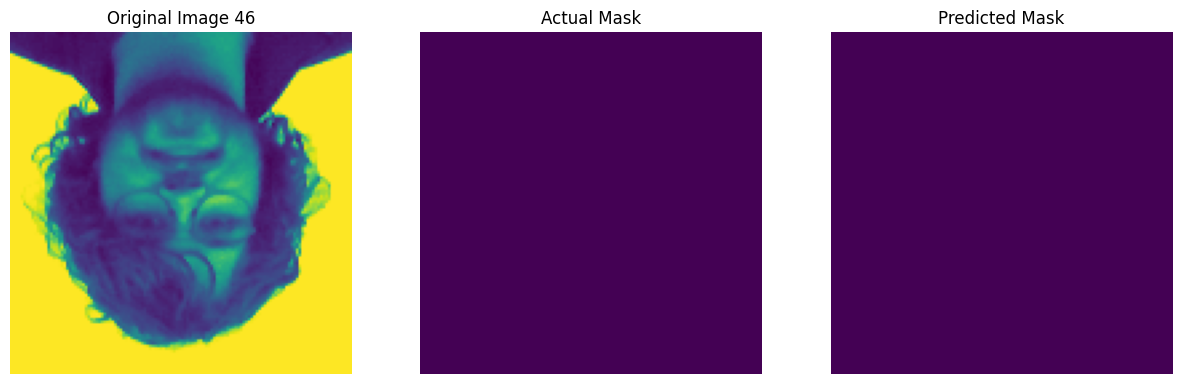

In [26]:
for i in [random.randint(0, 100) for i in range(10)]:
    plot_preds(i)

In [27]:
#Saving the model
unet.save('unet_model_2.keras')

In [28]:
# unet = modelLoading("unet_model.keras")


In [29]:
# for i in [random.randint(0, 100) for i in range(3)]:
#     plot_preds(i)